# Identificando patrones de consumo


## Objetivo de esta etapa

En esta sección, nos enfocamos en analizar los datos históricos para identificar patrones y tendencias en el uso del transporte público, incluyendo algunos análisis temporales, diferencias entre días laborables y fines de semana, variaciones estacionales, y analizar la integración de nuevas variables.

#### Recoleción de datos

Este conjunto de datos proviene de fuentes oficiales proporcionadas por el municipio de General Pueyrredón y el Ministerio de Transporte de la Nación, así como de los datos abiertos de la Nación Argentina. Los datos han sido recopilados de manera oficial y se utilizan con fines de análisis y evaluación. Los datos presentados aquí cumplen con los estándares de Protección de la Privacidad y Protección de la Propiedad Intelectual. No contienen información personal ni sensible de ningun tipo.

## Imports

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import altair as alt

import holidays
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import FuncFormatter

# Ajustes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

### Carga del dataset

In [2]:
df = pd.read_csv("Datasets/sube.csv")

# Nos aseguramos que la columna tenga el formato deseado
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
display(df.head(10))

DATE  DAY  MONTH  YEAR        COMPANY  LINE_ID  TICKETS
0 2020-01-01    1      1  2020     25 DE MAYO      501      315
1 2020-01-01    1      1  2020  PERALTA RAMOS      511    11463
2 2020-01-01    1      1  2020  PERALTA RAMOS      512     1889
3 2020-01-01    1      1  2020     25 DE MAYO      521     2729
4 2020-01-01    1      1  2020     25 DE MAYO      522     4010
5 2020-01-01    1      1  2020     25 DE MAYO      523     4791
6 2020-01-01    1      1  2020     25 DE MAYO      525      253
7 2020-01-01    1      1  2020  12 DE OCTUBRE      531     2339
8 2020-01-01    1      1  2020  12 DE OCTUBRE      532     1982
9 2020-01-01    1      1  2020  12 DE OCTUBRE      533     2425

### Exploración inicial de datos

Veamos las dimensiones

In [3]:
df.shape

(39245, 7)

Podemos observar que el dataframe resultante contiene 39245 filas en 7 columnas

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39245 entries, 0 to 39244
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     39245 non-null  datetime64[ns]
 1   DAY      39245 non-null  int64         
 2   MONTH    39245 non-null  int64         
 3   YEAR     39245 non-null  int64         
 4   COMPANY  39245 non-null  object        
 5   LINE_ID  39245 non-null  int64         
 6   TICKETS  39245 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 2.1+ MB


In [5]:
df.isna().sum().sort_values(ascending=False)

DATE       0
DAY        0
MONTH      0
YEAR       0
COMPANY    0
LINE_ID    0
TICKETS    0
dtype: int64

La estructura proporcionada revela una tabla con 39,245 registros y 7 columnas. Todas las columnas contienen datos no nulos, lo que indica la ausencia de valores faltantes.

In [6]:
duplicates = df.duplicated()
print(df[duplicates])

Empty DataFrame
Columns: [DATE, DAY, MONTH, YEAR, COMPANY, LINE_ID, TICKETS]
Index: []


No se observan valores duplicados

Observemos las variables numericas:

In [7]:
numerical_features = df['TICKETS'].describe()
display(numerical_features)

count    39245.000000
mean      6189.114180
std       5208.712114
min          1.000000
25%       2431.000000
50%       4938.000000
75%       8464.000000
max      40067.000000
Name: TICKETS, dtype: float64

La gran diferencia entre el valor mínimo (1) y el valor máximo (40,067) junto con una desviación estándar alta indica que hay una variabilidad significativa en la cantidad de pasajes vendidos. La mediana (4,938) es menor que la media (6,189), lo que sugiere que la distribución podría estar sesgada a la derecha (hacia valores más altos). Esto podría significar que hay algunos días con ventas extremadamente altas que elevan la media. Cabe recordar que tenemos periodos afectados por la pandemia.

In [8]:
# Listamos las columnas categóricas
categorical_columns = ['DAY', 'MONTH', 'YEAR', 'LINE_ID', 'COMPANY']

# Convertimos a tipo 'category'
for col in categorical_columns:
    df[col] = df[col].astype('category')

describe_categoricas = df[categorical_columns].describe(include='category')
print(describe_categoricas)

          DAY  MONTH   YEAR  LINE_ID     COMPANY
count   39245  39245  39245    39245       39245
unique     31     12      4       28           5
top        14     12   2023      715  25 DE MAYO
freq     1308   3383  10210     1453       19529


En primera instancia podemos observar que hay 28 lineas de transporte, operadas por 5 empresas. La distribución de días y meses parece estar dentro de lo esperable, con algunos días y meses siendo más frecuentes. Los datos están distribuidos en cuatro años, con una mayor cantidad de registros en el año 2023. La línea 715 y la compañía "25 DE MAYO" son las más representadas en el dataset.

Volvemos a operar las columnas en entero

In [9]:
# Listar las columnas categóricas
categorical_columns = ['DAY', 'MONTH', 'YEAR', 'LINE_ID']

# Convertir a tipo 'category'
for col in categorical_columns:
    df[col] = df[col].astype('int')

Veamos si tenemos dias sin registros en nuestra serie temporal:

In [10]:
# Verificar la completitud de los registros para cada mes y año
monthly_completeness = df.groupby(['YEAR', 'MONTH', 'DAY']).size().unstack(fill_value=0)
incomplete_records = monthly_completeness.apply(lambda x: x[x == 0].index.tolist(), axis=1)
incomplete_records = incomplete_records[incomplete_records.apply(len) > 0]
print(f'Registros incompletos por mes y año:\n\n{incomplete_records}')

Registros incompletos por mes y año:

YEAR  MONTH
2020  2            [30, 31]
      4                [31]
      6                [31]
      7                 [7]
      9                [31]
      11               [31]
2021  2        [29, 30, 31]
      4                [31]
      5                [17]
      6                [31]
      9                [31]
      10               [12]
      11               [31]
2022  2        [29, 30, 31]
      4                [31]
      5                [17]
      6                [31]
      9                [31]
      10               [12]
      11               [31]
2023  2        [29, 30, 31]
      4                [31]
      6                [31]
      9                [31]
      11               [31]
dtype: object


Podemos observar que efectivamente hay dias sin registros, pero sacando los meses que no tienen 31 dias (Meses: 4, 6, 9, 11), o el caso de 2020 que febrero tiene 29, nos quedaria asi:

| YEAR | MONTH | DAY  |
|------|-------|------|
| 2020 | 7     | [7]  |
| 2021 | 5     | [17] |
|      | 10    | [12] |
| 2022 | 5     | [17] |
|      | 10    | [12] |

Ahora que sabemos que existen dias faltantes, busquemos sus posibles causas:

7 de julio de 2020: Paro de transporte  
17 de mayo de 2021: Paro de transporte  
12 de octubre de 2021: Paro de transporte   
17 de mayo de 2022: Paro de transporte  
12 de octubre de 2022: Paro de transporte    

Ahora veamos información faltante de las lineas operadas:

In [11]:
line_year_crosstab = pd.crosstab(df['YEAR'], df['LINE_ID'])
line_year_crosstab

LINE_ID  501  511  512  521  522  523  525  531  532  533  541  542  543  551  552  553  554  555  562  563  571  573  581  591  593  715  717  720
YEAR                                                                                                                                               
2020     359  360  360  358  358  359  352  360  352  353  358  359  183  359  358  348  358  358  361  358  359  358  360  358  359  364  359    9
2021     361  362  362  362  362  362  362  362  356  356  362  362  362  362  362  362  362  362  362  362  362  362  362  362  362  362  362    8
2022     361  362  362  362  362  362  362  362  356  356  362  362  362  362  362  362  362  362  362  362  362  362  362  362  362  362  362    8
2023     364  365  365  365  365  366  365  365  365  365  365  365  365  367  365  365  365  365  366  365  366  366  365  366  365  365  365  349

Podemos apreciar que la linea 543 para 2020 no tiene suficientes datos. Por otro lado la linea 720 directamente tiene datos solo de 2023. 

Con respecto a la linea 523 la vamos a dejar, ya que seguramente no entrenemos el modelo con 2020, que de por si es un outlier todo el periodo. Por el lado de la linea 720, al no tener informacion suficiente, vamos a optar por descartarla del analisis y la predicción.

In [12]:
df = df[df['LINE_ID'] != 720]

Eliminada la linea 720, procedemos a completar los datos faltantes. Aqui se presentan varios enfoques, el que voy a utilizar es la interpolación. Esto es asi, debido a que buscamos generalizar, los dias faltantes no afetan el global de nuestros datos, y nuestro modelo no esta enfocado a predecir paros de transporte, sino mas bien la demanda.

### Completamos los tickets faltantes

Como primer paso, vamos a obtener una lista de las lineas unicas, luego vamos a filtrar nuestro df por cada linea unica recorriendo las fechas de principio a fin, si encuentra un valor faltante que aplique interpolacion entre el dia anterior y el siguiente.

In [13]:
# # Convertimos la columna DATE a tipo datetime si no lo está ya
# df['DATE'] = pd.to_datetime(df['DATE'])

# # Generamos un rango de fechas desde el 1 de enero de 2020 hasta el 31 de diciembre de 2023
# full_date_range = pd.date_range(start='2020-01-01', end='2023-12-31')

# # Obtenemos los LINE_ID únicos
# unique_line_ids = df['LINE_ID'].unique()

# # Creamos un DataFrame de referencia con todas las combinaciones de fechas y LINE_ID
# reference_df = pd.MultiIndex.from_product([full_date_range, unique_line_ids], names=['DATE', 'LINE_ID']).to_frame(index=False)

# # Hacemos un merge con el DataFrame original para identificar los días faltantes
# merged_df = reference_df.merge(df, on=['DATE', 'LINE_ID'], how='left')

# # Rellenamos los valores de COMPANY hacia adelante para manejar los casos de adquisición, como vamos a ver mas adelante
# merged_df['COMPANY'] = merged_df.groupby('LINE_ID')['COMPANY'].fillna(method='ffill')

# # Lista para almacenar los DataFrames interpolados
# interpolated_dfs = []

# # Recorremos el DataFrame resultante buscando los valores de TICKETS faltantes
# for line_id in unique_line_ids:
#     line_df = merged_df[merged_df['LINE_ID'] == line_id].sort_values(by='DATE')
    
#     # Identificamos los días faltantes antes de la interpolación
#     missing_days = line_df[line_df['TICKETS'].isnull()]['DATE']
    
#     # Interpolamos los valores de TICKETS
#     line_df['TICKETS'] = line_df['TICKETS'].interpolate(method='linear').round().astype('Int64')

#     # Identificamos las filas donde los valores de TICKETS fueron interpolados
#     interpolated_days = line_df[line_df['DATE'].isin(missing_days)]
    
#     # Imprimimos los días faltantes
#     if not missing_days.empty:
#         print(f"Día perdido para LINE_ID: {line_id}:")
#         print(missing_days.tolist())

#     # Rellenamos las columnas DAY, MONTH, y YEAR
#     interpolated_days['DAY'] = interpolated_days['DATE'].dt.day
#     interpolated_days['MONTH'] = interpolated_days['DATE'].dt.month
#     interpolated_days['YEAR'] = interpolated_days['DATE'].dt.year

#     # Agregamos el DataFrame interpolado a la lista
#     interpolated_dfs.append(interpolated_days)

# # Concatenamos todos los DataFrames interpolados
# interpolated_df = pd.concat(interpolated_dfs, ignore_index=True)

# # Concatenamos el DataFrame original con el DataFrame interpolado
# complete_df = pd.concat([df, interpolated_df], ignore_index=True)

# # Ordenamos por DATE y LINE_ID
# complete_df = complete_df.sort_values(by=['DATE', 'LINE_ID']).reset_index(drop=True)

# # Nos aseguramos que la salida sea entera
# complete_df['LINE_ID'] = pd.to_numeric(complete_df['LINE_ID'], errors='coerce').astype('Int64')

Observemos las filas generadas:

In [14]:
# interpolated_df.head(30)

Comprobamos la falta de datos nuevamente:

In [15]:
# line_year_crosstab = pd.crosstab(complete_df['YEAR'], complete_df['LINE_ID'])
# line_year_crosstab

Nota: 2020 dispone de 366 días. En la parte del modelado veremos como esto nos puede afectar.

En la prueba observamos que efectivamente ahora disponemos de los datos por linea por cada dia de nuestro dataset. Aunque podriamos examinar mas en detalle una linea al azar:

In [16]:
# df[(df['DATE'] >= '2020-06-27') & (df['DATE'] <= '2020-07-17') & (df['LINE_ID'] == 501)]

Sabemos que para la linea 501 en Julio, los dias 2 y el periodo del 4 al 8 estaban como faltantes. Observamos que la interpolacion es correcta.

Ahora que disponemos de toda la serie temporal para todas las lineas de transporte pasamos a usar el dataframe resultante:

In [17]:
# df = complete_df.copy()

# Outliers

Observemos sobre la variable objetivo los valores anomalos

Número de outliers: 1330


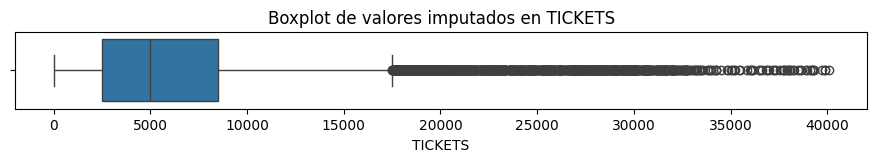

In [18]:
Q1 = df['TICKETS'].quantile(0.25)
Q3 = df['TICKETS'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los valores no anómalos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar valores anómalos
outliers = df[(df['TICKETS'] < lower_bound) | (df['TICKETS'] > upper_bound)]
print(f"Número de outliers: {outliers.shape[0]}")

# Visualizar el resultado
plt.figure(figsize=(11, 1))
sns.boxplot(x=df['TICKETS'])
plt.title('Boxplot de valores imputados en TICKETS')
plt.show()

Desglosemos estos por cada linea de transporte:

In [19]:
# Ordenar el DataFrame por TICKETS
df_sorted = df.sort_values(by='TICKETS', ascending=False)

# Seleccionar solo la columna TICKETS para calcular Z-scores
numeric_col = 'TICKETS'

# Calcular los Z-scores para la columna TICKETS
df_sorted['Z_SCORE'] = stats.zscore(df_sorted[numeric_col])

# Umbral para identificar outliers
umbral = 3
df_sorted['IS_OUTLIER'] = np.abs(df_sorted['Z_SCORE']) > umbral

# Identificar y contar los outliers por LINE_ID
outliers_by_line_id = df_sorted[df_sorted['IS_OUTLIER']].groupby('LINE_ID').size().reset_index(name='NUM_OUTLIERS')

# Mostrar los resultados
print(outliers_by_line_id)

   LINE_ID  NUM_OUTLIERS
0      511           627
1      523             1
2      531             2
3      551            16
4      571            34


Podemos ver que existen valores atipicos, mayormente se trata de la linea 511, que dispone de varios ramales o recorridos, la mas utilizada por turistas y marplatenses en epocas de verano para trasladarse a las playas, además esta linea contiene buses dobles, pudiendo disponer de hasta 60 asientos.

Por el momento los outliers se quedan, ya que confiamos en que son datos reales. Al momento del modelado vamos a evaluar y realizar diferentes pruebas.

## Analisis univariado 2020 - 2023

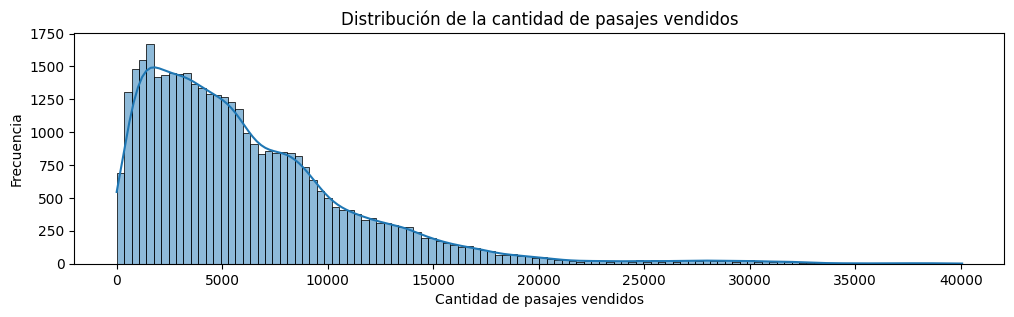

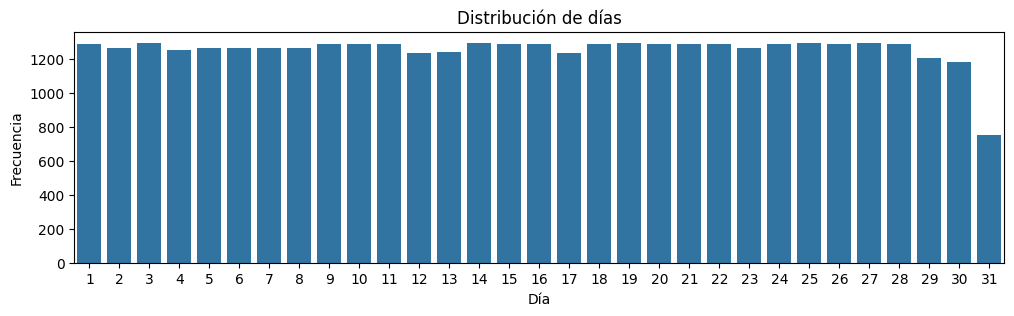

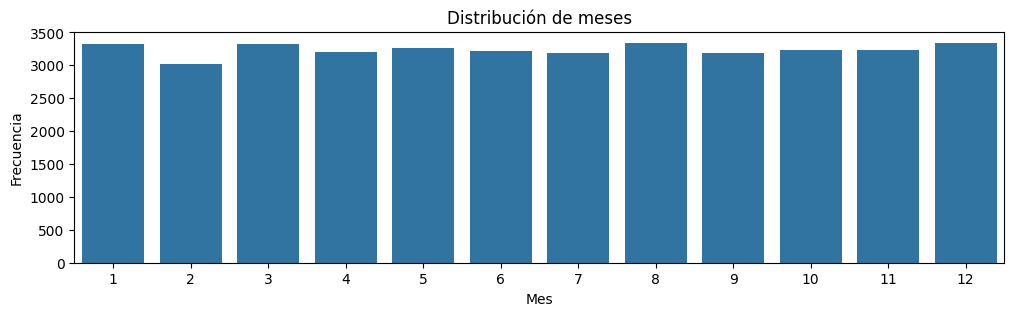

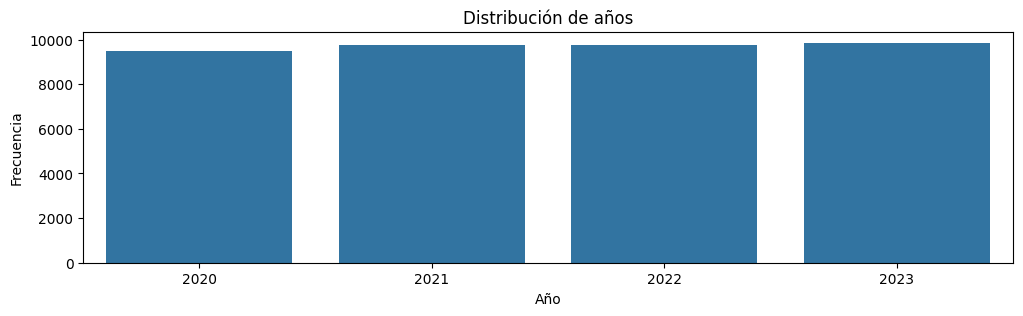

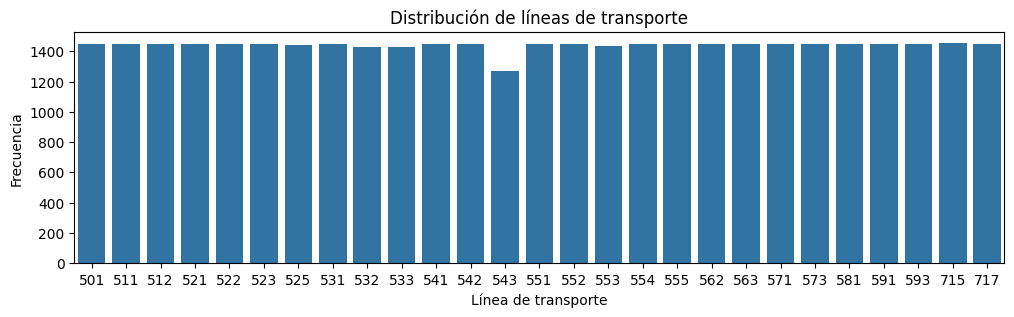

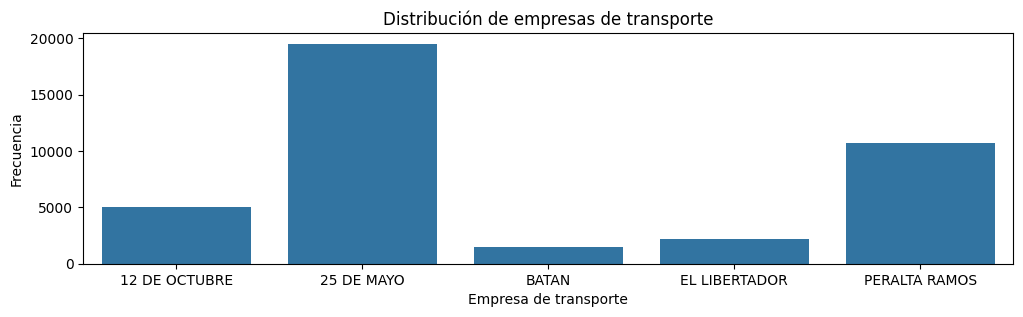

In [20]:
# Análisis de la variable objetivo: TICKETS
plt.figure(figsize=(12, 3))
sns.histplot(df['TICKETS'], kde=True)
plt.title('Distribución de la cantidad de pasajes vendidos')
plt.xlabel('Cantidad de pasajes vendidos')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable DAY
plt.figure(figsize=(12, 3))
sns.countplot(data=df, x='DAY')
plt.title('Distribución de días')
plt.xlabel('Día')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable MONTH
plt.figure(figsize=(12, 3))
sns.countplot(data=df, x='MONTH')
plt.title('Distribución de meses')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable YEAR
plt.figure(figsize=(12, 3))
sns.countplot(data=df, x='YEAR')
plt.title('Distribución de años')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable LINE_ID
plt.figure(figsize=(12, 3))
sns.countplot(data=df, x='LINE_ID')
plt.title('Distribución de líneas de transporte')
plt.xlabel('Línea de transporte')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable COMPANY
plt.figure(figsize=(12, 3))
sns.countplot(data=df, x='COMPANY')
plt.title('Distribución de empresas de transporte')
plt.xlabel('Empresa de transporte')
plt.ylabel('Frecuencia')
plt.show()

## Analisis univariado 2021 - 2023

Teniendo en cuenta el desempeño irregular de 2020, propongo analizar la linea temporal completa, y además el mismo periodo sin 2020.

In [21]:
df.head()

DATE  DAY  MONTH  YEAR        COMPANY  LINE_ID  TICKETS
0 2020-01-01    1      1  2020     25 DE MAYO      501      315
1 2020-01-01    1      1  2020  PERALTA RAMOS      511    11463
2 2020-01-01    1      1  2020  PERALTA RAMOS      512     1889
3 2020-01-01    1      1  2020     25 DE MAYO      521     2729
4 2020-01-01    1      1  2020     25 DE MAYO      522     4010

In [22]:
# Nos reservamos 2020 para el analisis final
df_20 = df[df['YEAR'] == 2020].copy().reset_index(drop=True)

# Analizamos con 2021 a 2023
df_21_23 = df[(df['YEAR'] >= 2021) & (df['YEAR'] <= 2023)].copy().reset_index(drop=True)

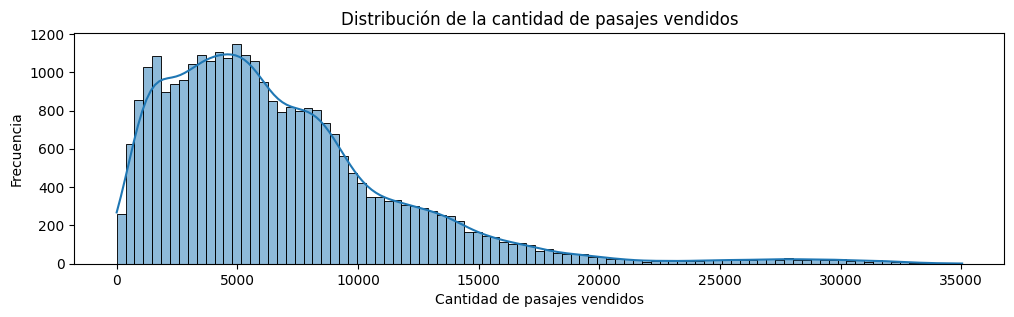

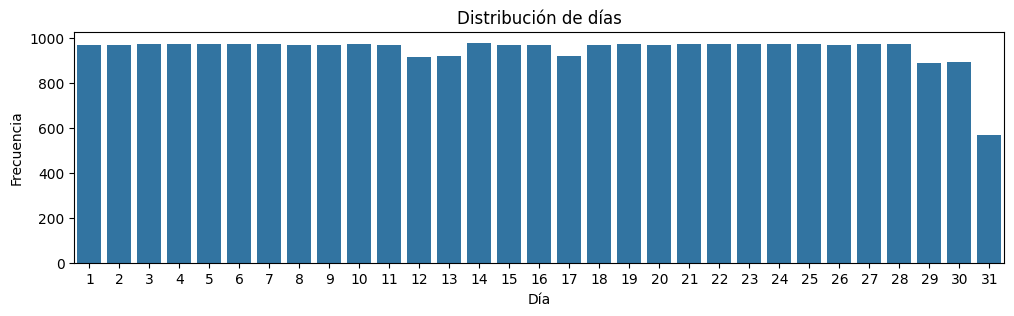

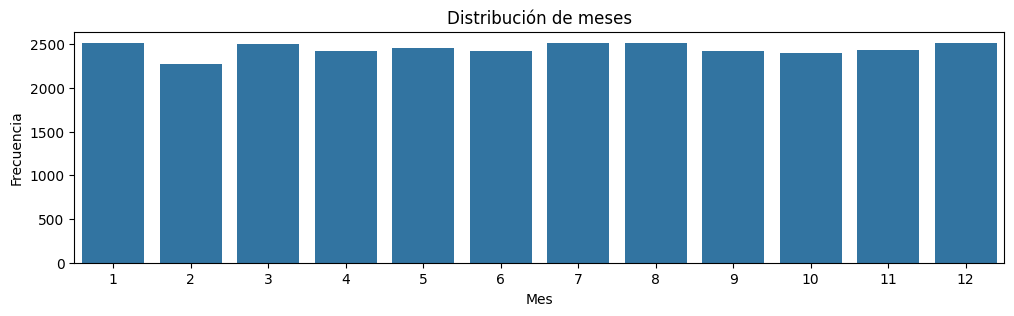

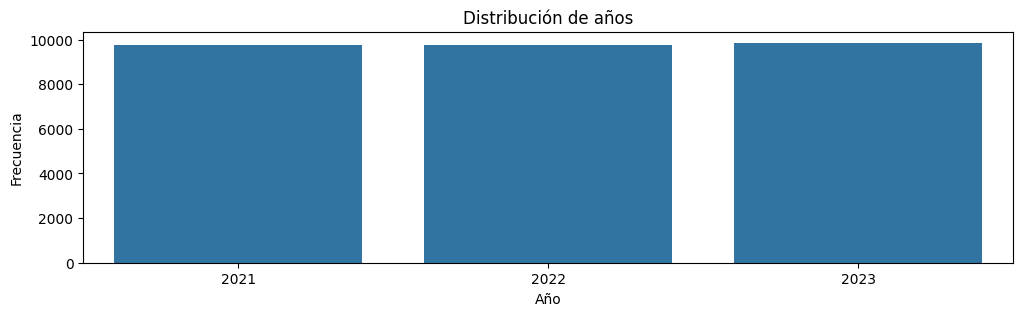

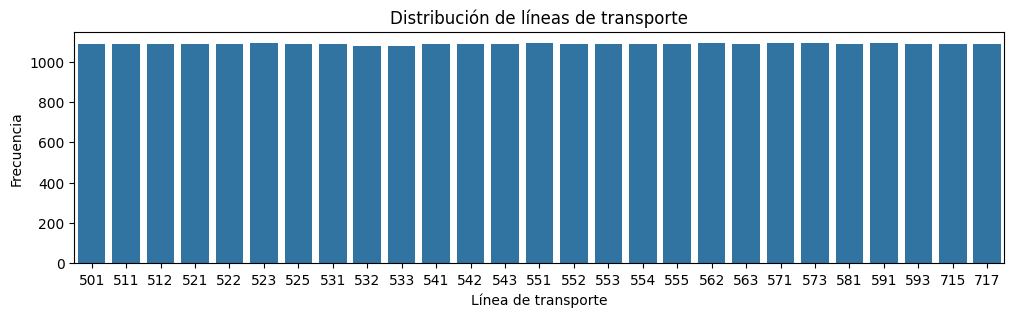

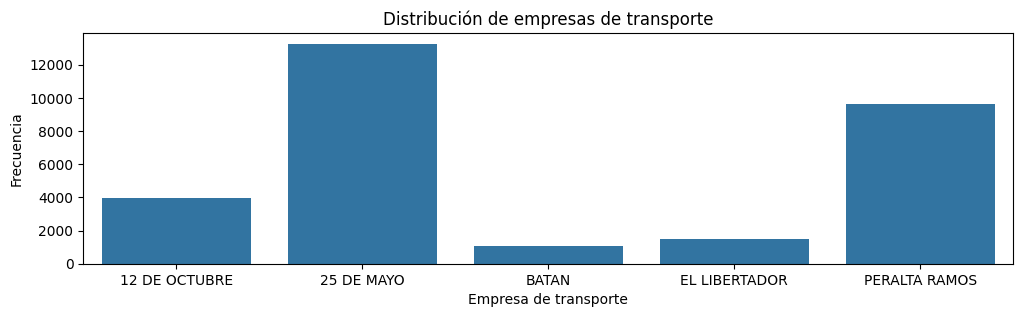

In [23]:
# Análisis de la variable objetivo: TICKETS
plt.figure(figsize=(12, 3))
sns.histplot(df_21_23['TICKETS'], kde=True)
plt.title('Distribución de la cantidad de pasajes vendidos')
plt.xlabel('Cantidad de pasajes vendidos')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable DAY
plt.figure(figsize=(12, 3))
sns.countplot(data=df_21_23, x='DAY')
plt.title('Distribución de días')
plt.xlabel('Día')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable MONTH
plt.figure(figsize=(12, 3))
sns.countplot(data=df_21_23, x='MONTH')
plt.title('Distribución de meses')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable YEAR
plt.figure(figsize=(12, 3))
sns.countplot(data=df_21_23, x='YEAR')
plt.title('Distribución de años')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable LINE_ID
plt.figure(figsize=(12, 3))
sns.countplot(data=df_21_23, x='LINE_ID')
plt.title('Distribución de líneas de transporte')
plt.xlabel('Línea de transporte')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la variable COMPANY
plt.figure(figsize=(12, 3))
sns.countplot(data=df_21_23, x='COMPANY')
plt.title('Distribución de empresas de transporte')
plt.xlabel('Empresa de transporte')
plt.ylabel('Frecuencia')
plt.show()

## Analisis Bivariado 2020 - 2023

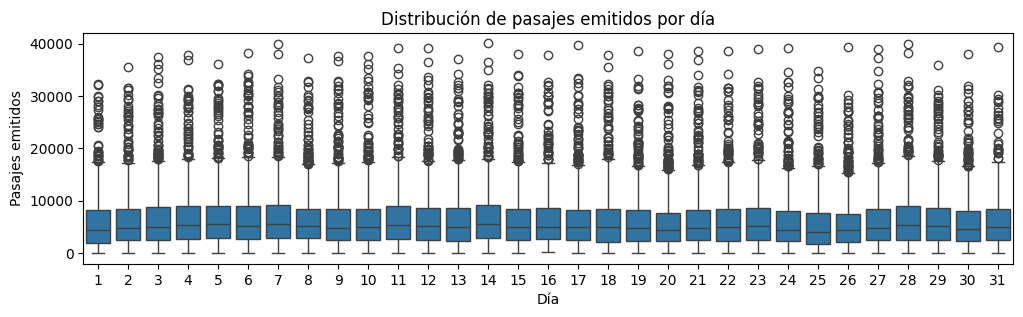

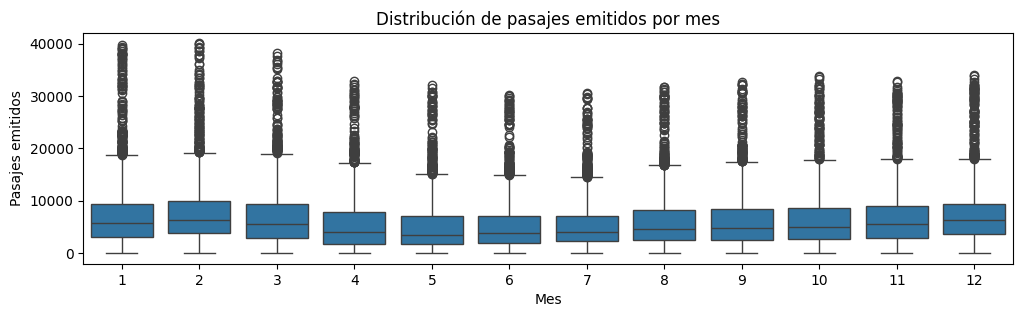

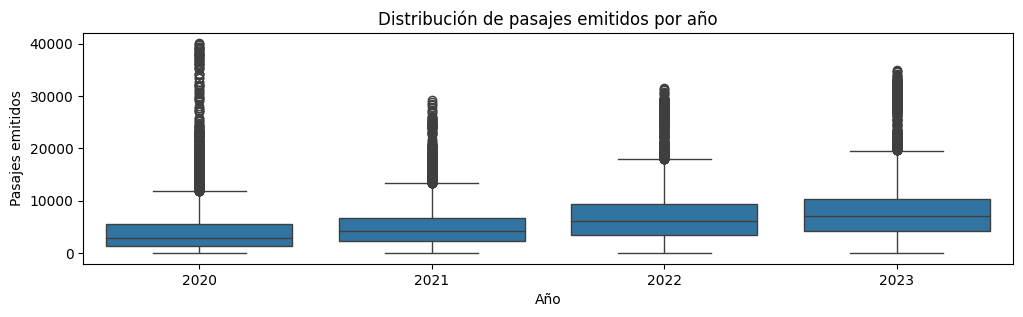

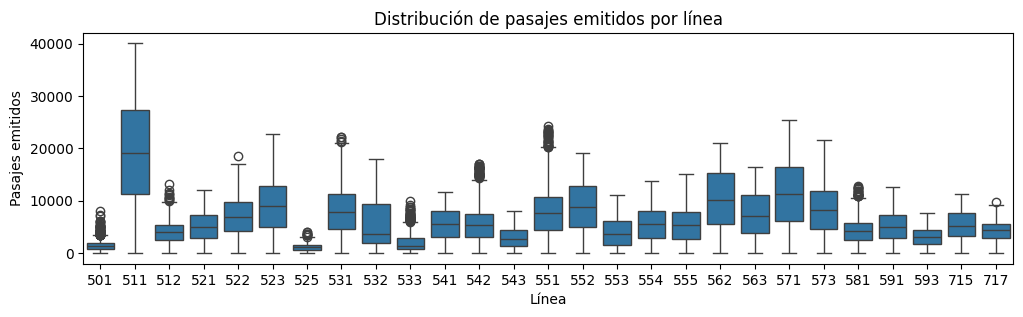

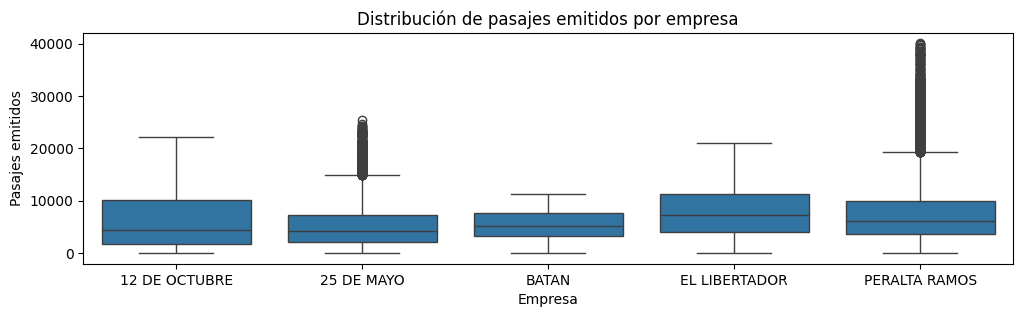

In [24]:
# Análisis bivariado: TICKETS vs. DAY
plt.figure(figsize=(12, 3))
sns.boxplot(data=df, x='DAY', y='TICKETS')
plt.title('Distribución de pasajes emitidos por día')
plt.xlabel('Día')
plt.ylabel('Pasajes emitidos')
plt.show()

# Análisis bivariado: TICKETS vs. MONTH
plt.figure(figsize=(12, 3))
sns.boxplot(data=df, x='MONTH', y='TICKETS')
plt.title('Distribución de pasajes emitidos por mes')
plt.xlabel('Mes')
plt.ylabel('Pasajes emitidos')
plt.show()

# Análisis bivariado: TICKETS vs. YEAR
plt.figure(figsize=(12, 3))
sns.boxplot(data=df, x='YEAR', y='TICKETS')
plt.title('Distribución de pasajes emitidos por año')
plt.xlabel('Año')
plt.ylabel('Pasajes emitidos')
plt.show()

# Análisis bivariado: TICKETS vs. LINE_ID
plt.figure(figsize=(12, 3))
sns.boxplot(data=df, x='LINE_ID', y='TICKETS')
plt.title('Distribución de pasajes emitidos por línea')
plt.xlabel('Línea')
plt.ylabel('Pasajes emitidos')
plt.show()

# Análisis bivariado: TICKETS vs. COMAPANY
plt.figure(figsize=(12, 3))
sns.boxplot(data=df, x='COMPANY', y='TICKETS')
plt.title('Distribución de pasajes emitidos por empresa')
plt.xlabel('Empresa')
plt.ylabel('Pasajes emitidos')
plt.show()

### Conclusiones

Variabilidad en la Demanda: Algunas líneas, como la 511, tienen una gran variabilidad en la demanda de pasajes, mientras que otras líneas tienen una demanda más consistente.

Valores Atípicos: La presencia de valores atípicos en varias líneas sugiere que hay días con demandas inusualmente altas o bajas.

Distribución de la Demanda: La mayoría de las líneas de transporte tienen una mediana baja en la cantidad de pasajes emitidos, lo que indica que hay unas pocas líneas con una alta demanda y muchas otras con una demanda moderada o baja.

## Analisis Bivariado 2021 - 2023

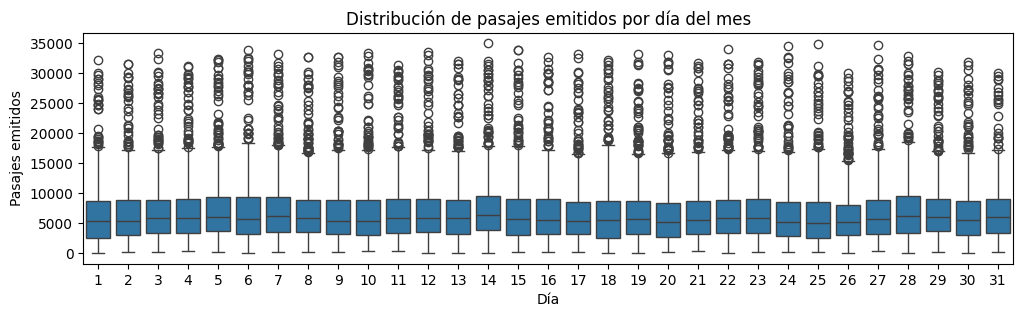

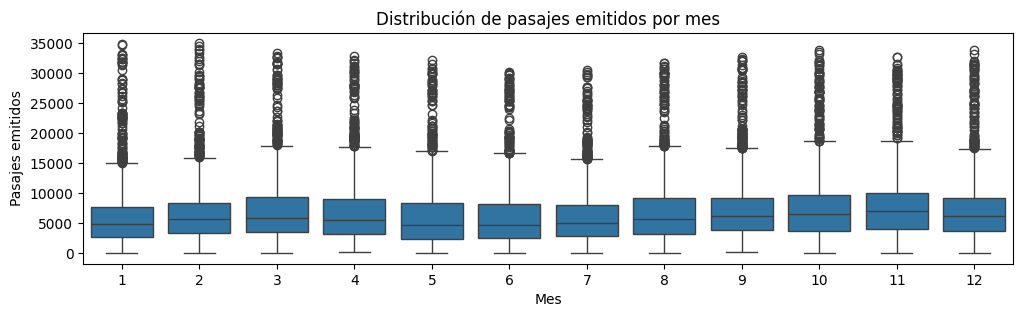

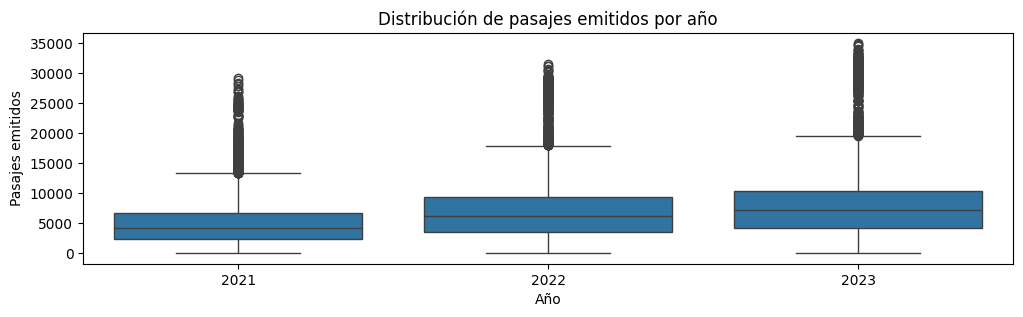

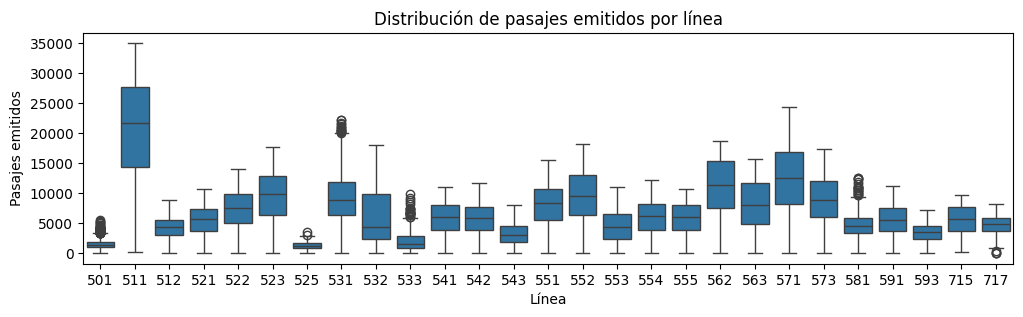

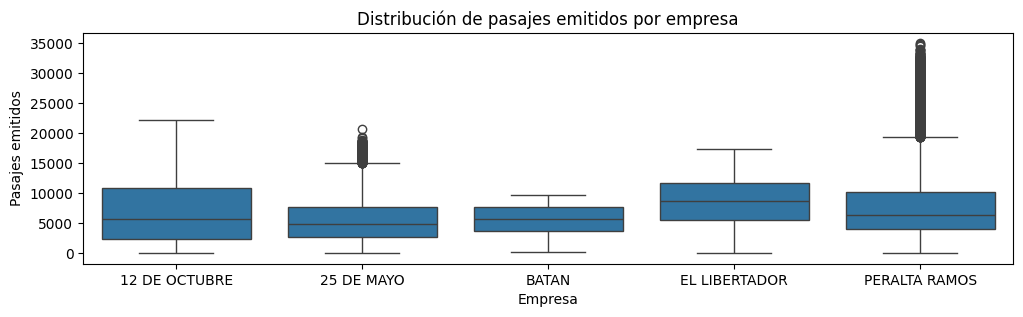

In [25]:
# Análisis bivariado: TICKETS vs. DAY
plt.figure(figsize=(12, 3))
sns.boxplot(data=df_21_23, x='DAY', y='TICKETS')
plt.title('Distribución de pasajes emitidos por día del mes')
plt.xlabel('Día')
plt.ylabel('Pasajes emitidos')
plt.show()

# Análisis bivariado: TICKETS vs. MONTH
plt.figure(figsize=(12, 3))
sns.boxplot(data=df_21_23, x='MONTH', y='TICKETS')
plt.title('Distribución de pasajes emitidos por mes')
plt.xlabel('Mes')
plt.ylabel('Pasajes emitidos')
plt.show()

# Análisis bivariado: TICKETS vs. YEAR
plt.figure(figsize=(12, 3))
sns.boxplot(data=df_21_23, x='YEAR', y='TICKETS')
plt.title('Distribución de pasajes emitidos por año')
plt.xlabel('Año')
plt.ylabel('Pasajes emitidos')
plt.show()

# Análisis bivariado: TICKETS vs. LINE_ID
plt.figure(figsize=(12, 3))
sns.boxplot(data=df_21_23, x='LINE_ID', y='TICKETS')
plt.title('Distribución de pasajes emitidos por línea')
plt.xlabel('Línea')
plt.ylabel('Pasajes emitidos')
plt.show()

# Análisis bivariado: TICKETS vs. COMAPANY
plt.figure(figsize=(12, 3))
sns.boxplot(data=df_21_23, x='COMPANY', y='TICKETS')
plt.title('Distribución de pasajes emitidos por empresa')
plt.xlabel('Empresa')
plt.ylabel('Pasajes emitidos')
plt.show()

## Creación de nuevas caracteristicas

Propongo transformar las fechas y obtener nuevos puntos de vista que logren aportar otra perspectiva de la informacion. Para esto primero vamos a obtener los dias festivos:

In [26]:
import holidays

# Obtenemos feriados
ar_holidays = holidays.Argentina(years=[2020, 2021, 2022, 2023, 2024])

# ====================================================================

# Agregamos las fechas que faltan
manual_holidays = {
    '2021-04-01': "Jueves santo",
    '2022-04-14': "Jueves santo",
    '2023-04-06': "Jueves santo",
    '2024-03-28': "Jueves santo"
}
ar_holidays.update(manual_holidays)

Tenemos los feriados, vamos ahora a buscar correlaciones entre dias anteriores, es decir que dia anterior puede ayudarnos a predecir el dia actual, luego lo incluimos como columnas y posteriormente evaluamos su utilidad ante el modelo:

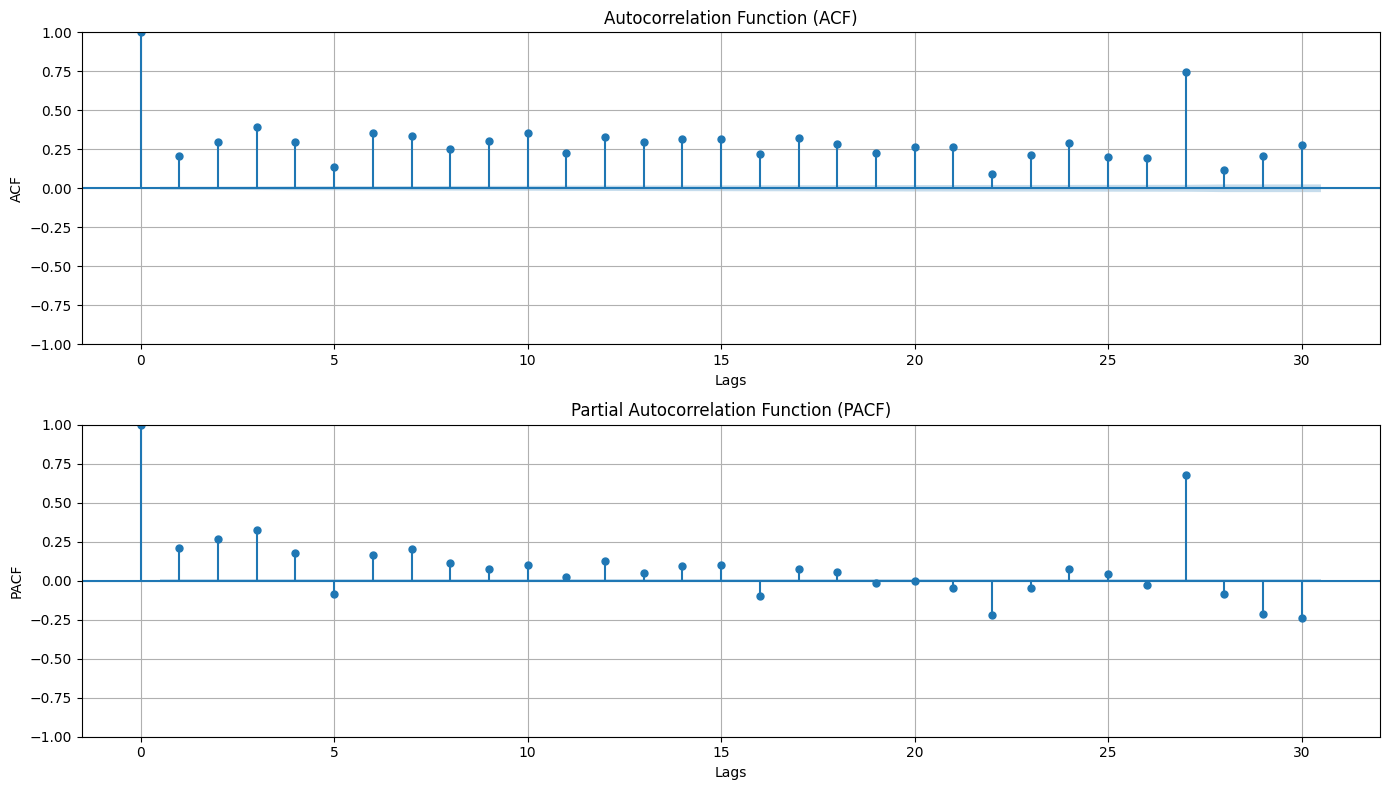

In [27]:
# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Crear el gráfico ACF y PACF con mejoras
plt.figure(figsize=(14, 8))

# Gráfico ACF
plt.subplot(211)
plot_acf(df['TICKETS'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)

# Gráfico PACF
plt.subplot(212)
plot_pacf(df['TICKETS'].dropna(), lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)

plt.tight_layout()
plt.show()

Aca podemos apreciar que el LAG_28 podria ser bueno explicando TICKETS

Teniendo esta información vamos a contruir las nuevas features a fin de poder apodar al modelo en su prediccion:

In [28]:
# Asegurarse de que la fecha sea correcta
df['DATE'] = pd.to_datetime(df['DATE'])

# ==================================================

# Ordenar por fecha
df = df.sort_values(by='DATE')

df['DAY_OF_MONTH_SIN'] = np.sin(2 * np.pi * df['DAY'] / 31)
df['DAY_OF_MONTH_COS'] = np.cos(2 * np.pi * df['DAY'] / 31)

# ==================================================

# Dia de la semana (int) > Lunes = 1 / Domingo = 7
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek + 1
df['DAY_OF_WEEK_SIN'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['DAY_OF_WEEK_COS'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)

# ==================================================

# Determina si es feriado
def is_holiday(date):
    return int(date in ar_holidays)

# Determina si es un día hábil (workday)
def is_workday(row):
    return 1 if row['DAY_OF_WEEK'] in range(1, 6) and not is_holiday(row['DATE']) else 0

# Crea la columna 'HOLIDAY'
df['HOLIDAY'] = df['DATE'].map(is_holiday)

# Aplica la función para crear la columna 'WORKDAY'
df['WORKDAY'] = df.apply(is_workday, axis=1)

# Fin de semana (int) Si = 1
df['WEEKEND'] = df['DAY_OF_WEEK'].apply(lambda x: 1 if x > 5 else 0)

# Asignar temporada en cuatrimestres agrupados por consumo
def assign_season(month):
    if month in [12, 1, 2, 3]:
        return 3 # Mayor demanda
    elif month in [4, 5, 6, 7]:
        return 1
    elif month in [8, 9, 10, 11]:
        return 2

df['SEASON'] = df['DATE'].dt.month.apply(assign_season)

# ==================================================

# Día del año
df['DAY_OF_YEAR'] = df['DATE'].dt.dayofyear
df['DAY_OF_YEAR_SIN'] = np.sin(2 * np.pi * df['DAY_OF_YEAR'] / 365)
df['DAY_OF_YEAR_COS'] = np.cos(2 * np.pi * df['DAY_OF_YEAR'] / 365)

# Semana del año
df['WEEK_OF_YEAR'] = df['DATE'].dt.isocalendar().week

df['WEEK_OF_MONTH'] = df['DATE'].apply(lambda d: (d.day - 1) // 7 + 1)

# Mes del año
df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)

def generate_lags(df, lags):
    df['DATE'] = pd.to_datetime(df['DATE'])  # Aseguro que DATE es de tipo datetime
    df = df.sort_values(by=['LINE_ID', 'DATE'])  # Ordeno el DataFrame por LINE_ID y DATE

    for lag in lags:
        lag_values = []
        for idx, row in df.iterrows():
            lag_date = row['DATE'] - timedelta(days=lag)
            lag_value = df[(df['LINE_ID'] == row['LINE_ID']) & (df['DATE'] == lag_date)]['TICKETS']
            if lag_value.empty:
                lag_values.append(0)  # Si no se encuentra la fecha, añadir 0
            else:
                lag_values.append(lag_value.values[0])
        df[f'LAG_{lag}'] = lag_values
    return df

# Definimos los lags deseados en días
lags = [1, 28]

# Generar las características de lag y diferencia
df = generate_lags(df, lags)

# Identificar columnas que pueden contener NaN
lag_columns = [f'LAG_{lag}' for lag in lags] 

df_21_23 = df[(df['YEAR'] >= 2021) & (df['YEAR'] <= 2023)]
display(df.head(20))

DATE  DAY  MONTH  YEAR     COMPANY  LINE_ID  TICKETS  DAY_OF_MONTH_SIN  DAY_OF_MONTH_COS  DAY_OF_WEEK  DAY_OF_WEEK_SIN  DAY_OF_WEEK_COS  HOLIDAY  WORKDAY  WEEKEND  SEASON  DAY_OF_YEAR  DAY_OF_YEAR_SIN  DAY_OF_YEAR_COS  WEEK_OF_YEAR  WEEK_OF_MONTH  MONTH_SIN  MONTH_COS  LAG_1  LAG_28
0   2020-01-01    1      1  2020  25 DE MAYO      501      315          0.201299          0.979530            3     4.338837e-01        -0.900969        1        0        0       3            1         0.017213         0.999852             1              1        0.5   0.866025      0       0
27  2020-01-02    2      1  2020  25 DE MAYO      501      816          0.394356          0.918958            4    -4.338837e-01        -0.900969        0        1        0       3            2         0.034422         0.999407             1              1        0.5   0.866025    315       0
55  2020-01-03    3      1  2020  25 DE MAYO      501      901          0.571268          0.820763            5    -9.749279e-01        -0.222521        0        1        0       3            3         0.051620         0.998667             1              1        0.5   0.866025    816       0
82  2020-01-04    4      1  2020  25 DE MAYO      501      920          0.724793          0.688967            6    -7.818315e-01         0.623490        0        0        1       3            4         0.068802         0.997630             1              1        0.5   0.866025    901       0
109 2020-01-05    5      1  2020  25 DE MAYO      501      415          0.848644          0.528964            7    -2.449294e-16         1.000000        0        0        1       3            5         0.085965         0.996298             1              1        0.5   0.866025    920       0
135 2020-01-06    6      1  2020  25 DE MAYO      501      530          0.937752          0.347305            1     7.818315e-01         0.623490        0        1        0       3            6         0.103102         0.994671             2              1        0.5   0.866025    415       0
161 2020-01-07    7      1  2020  25 DE MAYO      501      903          0.988468          0.151428            2     9.749279e-01        -0.222521        0        1        0       3            7         0.120208         0.992749             2              1        0.5   0.866025    530       0
187 2020-01-08    8      1  2020  25 DE MAYO      501      900          0.998717         -0.050649            3     4.338837e-01        -0.900969        0        1        0       3            8         0.137279         0.990532             2              2        0.5   0.866025    903       0
214 2020-01-09    9      1  2020  25 DE MAYO      501      874          0.968077         -0.250653            4    -4.338837e-01        -0.900969        0        1        0       3            9         0.154309         0.988023             2              2        0.5   0.866025    900       0
240 2020-01-10   10      1  2020  25 DE MAYO      501      789          0.897805         -0.440394            5    -9.749279e-01        -0.222521        0        1        0       3           10         0.171293         0.985220             2              2        0.5   0.866025    874       0
266 2020-01-11   11      1  2020  25 DE MAYO      501      882          0.790776         -0.612106            6    -7.818315e-01         0.623490        0        0        1       3           11         0.188227         0.982126             2              2        0.5   0.866025    789       0
292 2020-01-12   12      1  2020  25 DE MAYO      501      668          0.651372         -0.758758            7    -2.449294e-16         1.000000        0        0        1       3           12         0.205104         0.978740             2              2        0.5   0.866025    882       0
319 2020-01-13   13      1  2020  25 DE MAYO      501      904          0.485302         -0.874347            1     7.818315e-01         0.623490        0        1        0       3        

Observemos el compoprtamiento de estas nuevas variables junto a la demanda de transporte (Rango 2021 - 2023):

In [29]:
df.tail()

DATE  DAY  MONTH  YEAR        COMPANY  LINE_ID  TICKETS  DAY_OF_MONTH_SIN  DAY_OF_MONTH_COS  DAY_OF_WEEK  DAY_OF_WEEK_SIN  DAY_OF_WEEK_COS  HOLIDAY  WORKDAY  WEEKEND  SEASON  DAY_OF_YEAR  DAY_OF_YEAR_SIN  DAY_OF_YEAR_COS  WEEK_OF_YEAR  WEEK_OF_MONTH     MONTH_SIN  MONTH_COS  LAG_1  LAG_28
39131 2023-12-27   27     12  2023  PERALTA RAMOS      717     5468     -7.247928e-01          0.688967            3     4.338837e-01        -0.900969        0        1        0       3          361    -6.880243e-02         0.997630            52              4 -2.449294e-16        1.0   5142    6640
39159 2023-12-28   28     12  2023  PERALTA RAMOS      717     4241     -5.712682e-01          0.820763            4    -4.338837e-01        -0.900969        0        1        0       3          362    -5.161967e-02         0.998667            52              4 -2.449294e-16        1.0   5468    7132
39187 2023-12-29   29     12  2023  PERALTA RAMOS      717     5677     -3.943559e-01          0.918958            5    -9.749279e-01        -0.222521        0        1        0       3          363    -3.442161e-02         0.999407            52              5 -2.449294e-16        1.0   4241    5160
39215 2023-12-30   30     12  2023  PERALTA RAMOS      717     5416     -2.012985e-01          0.979530            6    -7.818315e-01         0.623490        0        0        1       3          364    -1.721336e-02         0.999852            52              5 -2.449294e-16        1.0   5677    5300
39243 2023-12-31   31     12  2023  PERALTA RAMOS      717     3375     -2.449294e-16          1.000000            7    -2.449294e-16         1.000000        0        0        1       3          365     6.432491e-16         1.000000            52              5 -2.449294e-16        1.0   5416    4725

In [30]:
df.columns

Index(['DATE', 'DAY', 'MONTH', 'YEAR', 'COMPANY', 'LINE_ID', 'TICKETS', 'DAY_OF_MONTH_SIN', 'DAY_OF_MONTH_COS', 'DAY_OF_WEEK', 'DAY_OF_WEEK_SIN', 'DAY_OF_WEEK_COS', 'HOLIDAY', 'WORKDAY', 'WEEKEND', 'SEASON', 'DAY_OF_YEAR', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS', 'WEEK_OF_YEAR', 'WEEK_OF_MONTH', 'MONTH_SIN', 'MONTH_COS', 'LAG_1', 'LAG_28'], dtype='object')

## Analisis bivariado: nuevas caracteristicas

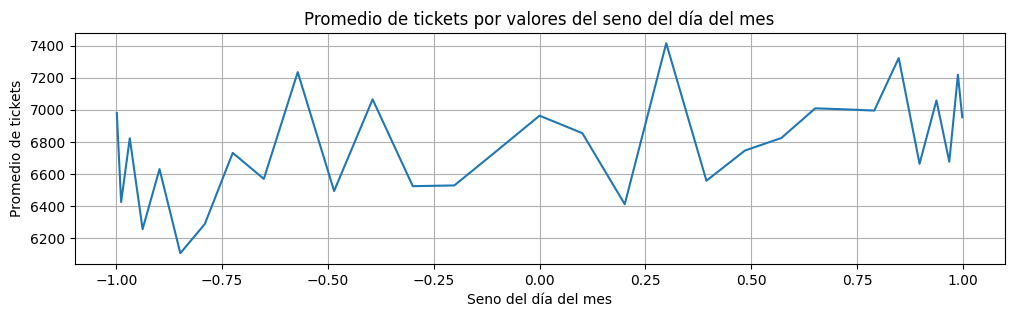

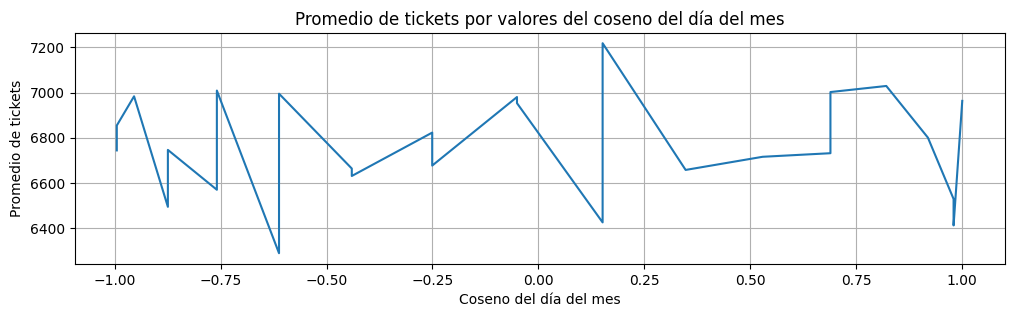

In [31]:
df_avg_sin = df_21_23.groupby('DAY_OF_MONTH_SIN')['TICKETS'].mean().reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(x='DAY_OF_MONTH_SIN', y='TICKETS', data=df_avg_sin)
plt.title('Promedio de tickets por valores del seno del día del mes')
plt.xlabel('Seno del día del mes')
plt.ylabel('Promedio de tickets')
plt.grid(True)
plt.show()

df_avg_cos = df_21_23.groupby('DAY_OF_MONTH_COS')['TICKETS'].mean().reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(x='DAY_OF_MONTH_COS', y='TICKETS', data=df_avg_cos)
plt.title('Promedio de tickets por valores del coseno del día del mes')
plt.xlabel('Coseno del día del mes')
plt.ylabel('Promedio de tickets')
plt.grid(True)
plt.show()

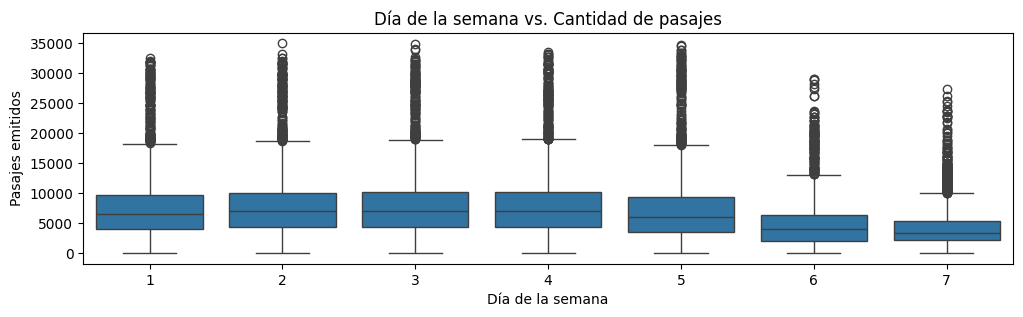

In [32]:
plt.figure(figsize=(12, 3))
sns.boxplot(x=df_21_23['DAY_OF_WEEK'], y=df_21_23['TICKETS'])
plt.title('Día de la semana vs. Cantidad de pasajes')
plt.xlabel('Día de la semana')
plt.ylabel('Pasajes emitidos')
plt.show()

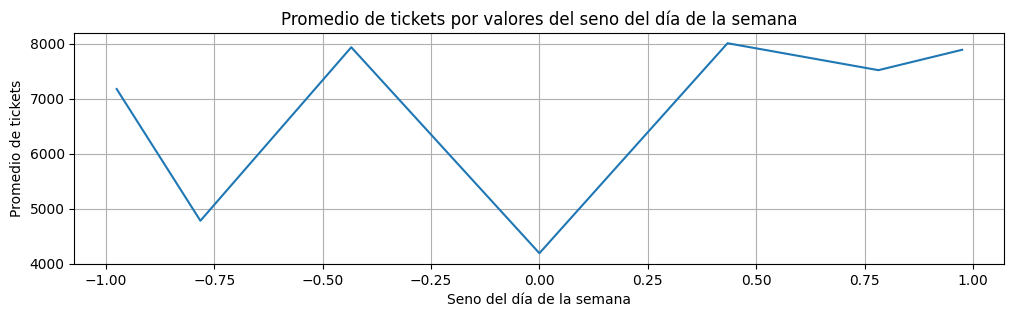

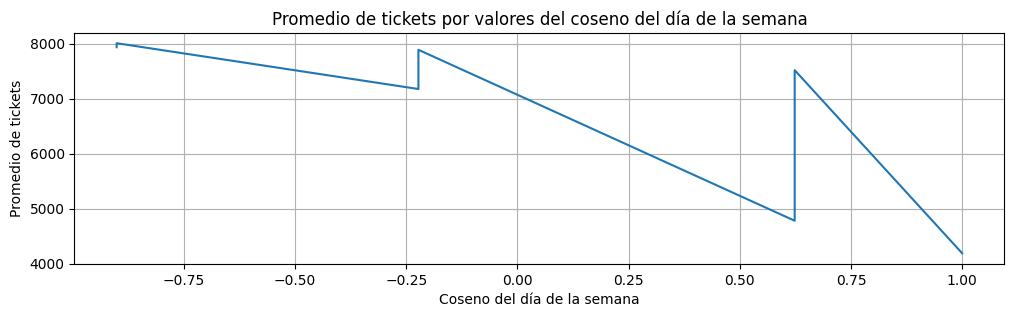

In [33]:
df_avg_sin = df_21_23.groupby('DAY_OF_WEEK_SIN')['TICKETS'].mean().reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(x='DAY_OF_WEEK_SIN', y='TICKETS', data=df_avg_sin)
plt.title('Promedio de tickets por valores del seno del día de la semana')
plt.xlabel('Seno del día de la semana')
plt.ylabel('Promedio de tickets')
plt.grid(True)
plt.show()

df_avg_cos = df_21_23.groupby('DAY_OF_WEEK_COS')['TICKETS'].mean().reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(x='DAY_OF_WEEK_COS', y='TICKETS', data=df_avg_cos)
plt.title('Promedio de tickets por valores del coseno del día de la semana')
plt.xlabel('Coseno del día de la semana')
plt.ylabel('Promedio de tickets')
plt.grid(True)
plt.show()

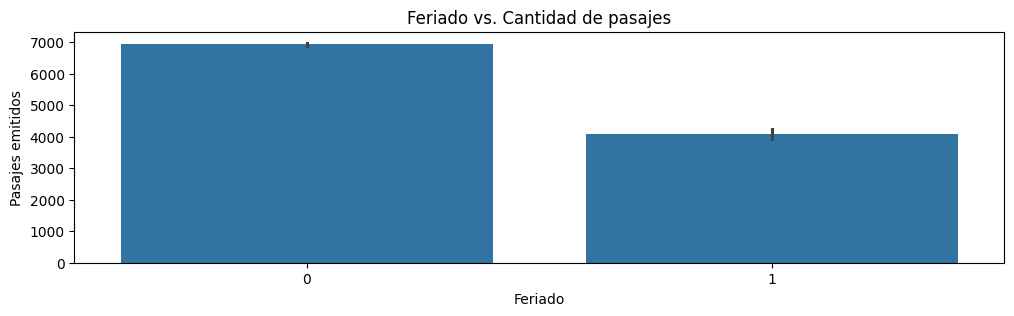

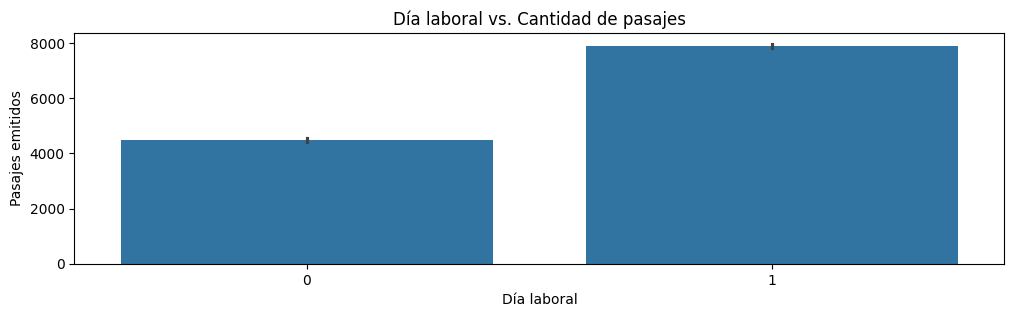

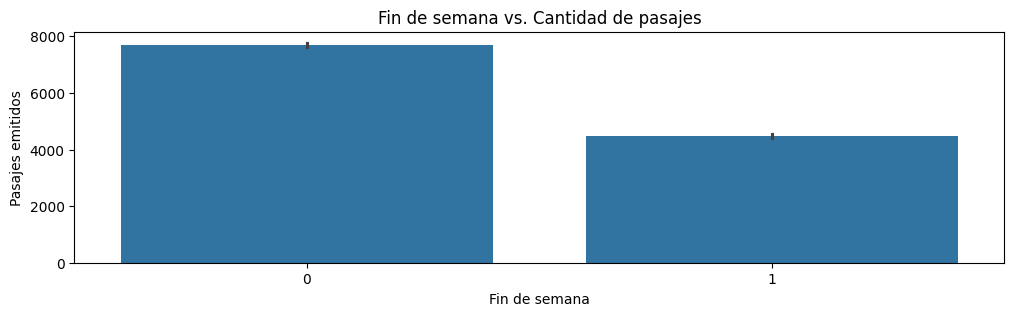

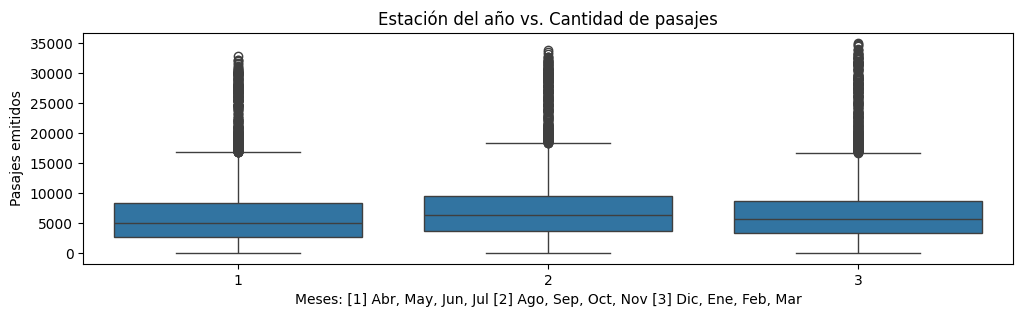

In [34]:
plt.figure(figsize=(12, 3))
sns.barplot(x=df_21_23['HOLIDAY'], y=df_21_23['TICKETS'])
plt.title('Feriado vs. Cantidad de pasajes')
plt.xlabel('Feriado')
plt.ylabel('Pasajes emitidos')
plt.show()

plt.figure(figsize=(12, 3))
sns.barplot(x=df_21_23['WORKDAY'], y=df_21_23['TICKETS'])
plt.title('Día laboral vs. Cantidad de pasajes')
plt.xlabel('Día laboral')
plt.ylabel('Pasajes emitidos')
plt.show()

plt.figure(figsize=(12, 3))
sns.barplot(x=df_21_23['WEEKEND'], y=df_21_23['TICKETS'])
plt.title('Fin de semana vs. Cantidad de pasajes')
plt.xlabel('Fin de semana')
plt.ylabel('Pasajes emitidos')
plt.show()

plt.figure(figsize=(12, 3))
sns.boxplot(x=df_21_23['SEASON'], y=df_21_23['TICKETS'])
plt.title('Estación del año vs. Cantidad de pasajes')
plt.xlabel('Meses: [1] Abr, May, Jun, Jul [2] Ago, Sep, Oct, Nov [3] Dic, Ene, Feb, Mar')
plt.ylabel('Pasajes emitidos')
plt.show()

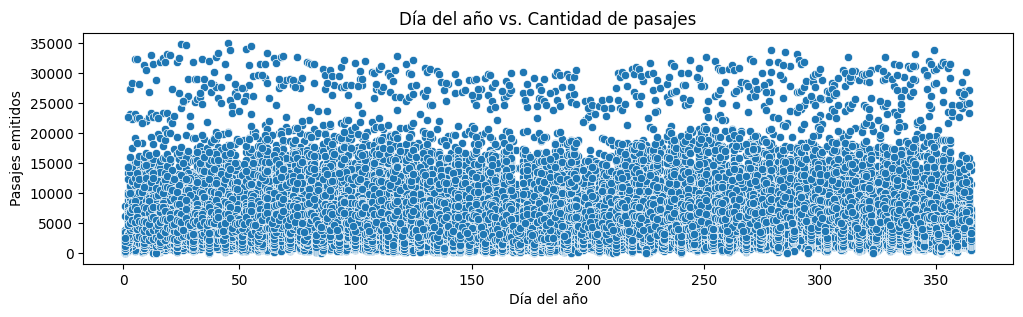

In [35]:
plt.figure(figsize=(12, 3))
sns.scatterplot(x=df_21_23['DAY_OF_YEAR'], y=df_21_23['TICKETS'])
plt.title('Día del año vs. Cantidad de pasajes')
plt.xlabel('Día del año')
plt.ylabel('Pasajes emitidos')
plt.show()

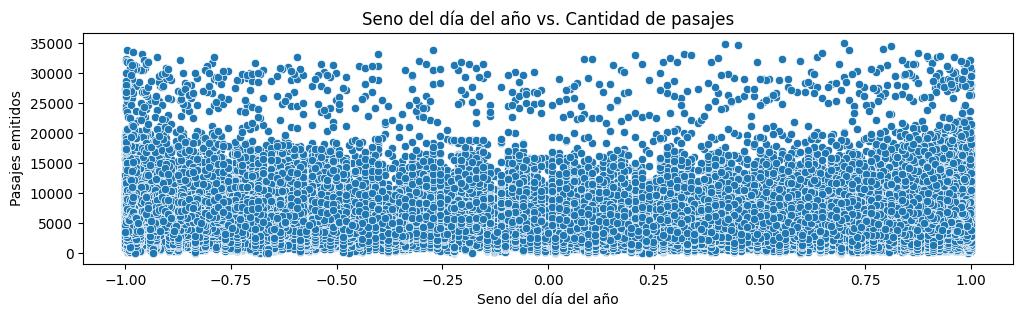

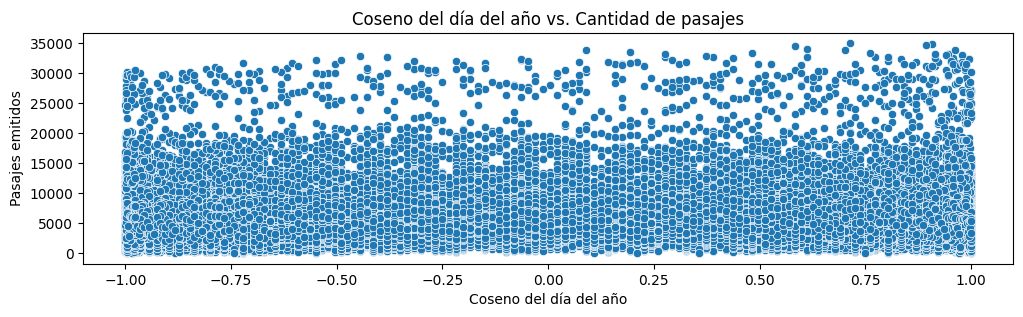

In [36]:
plt.figure(figsize=(12, 3))
sns.scatterplot(x=df_21_23['DAY_OF_YEAR_SIN'], y=df_21_23['TICKETS'])
plt.title('Seno del día del año vs. Cantidad de pasajes')
plt.xlabel('Seno del día del año')
plt.ylabel('Pasajes emitidos')
plt.show()

plt.figure(figsize=(12, 3))
sns.scatterplot(x=df_21_23['DAY_OF_YEAR_COS'], y=df_21_23['TICKETS'])
plt.title('Coseno del día del año vs. Cantidad de pasajes')
plt.xlabel('Coseno del día del año')
plt.ylabel('Pasajes emitidos')
plt.show()


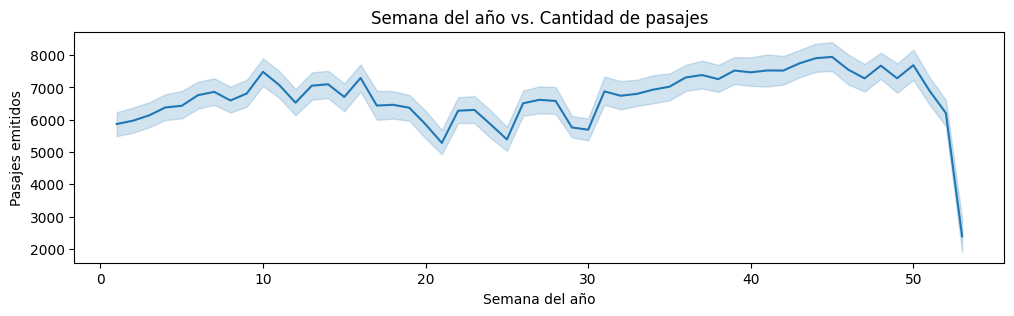

In [37]:
plt.figure(figsize=(12, 3))
sns.lineplot(x=df_21_23['WEEK_OF_YEAR'], y=df_21_23['TICKETS'])
plt.title('Semana del año vs. Cantidad de pasajes')
plt.xlabel('Semana del año')
plt.ylabel('Pasajes emitidos')
plt.show()


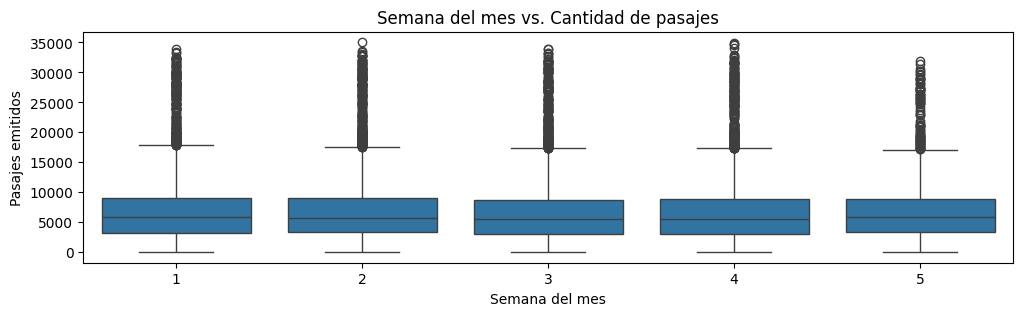

In [38]:
plt.figure(figsize=(12, 3))
sns.boxplot(x=df_21_23['WEEK_OF_MONTH'], y=df_21_23['TICKETS'])
plt.title('Semana del mes vs. Cantidad de pasajes')
plt.xlabel('Semana del mes')
plt.ylabel('Pasajes emitidos')
plt.show()


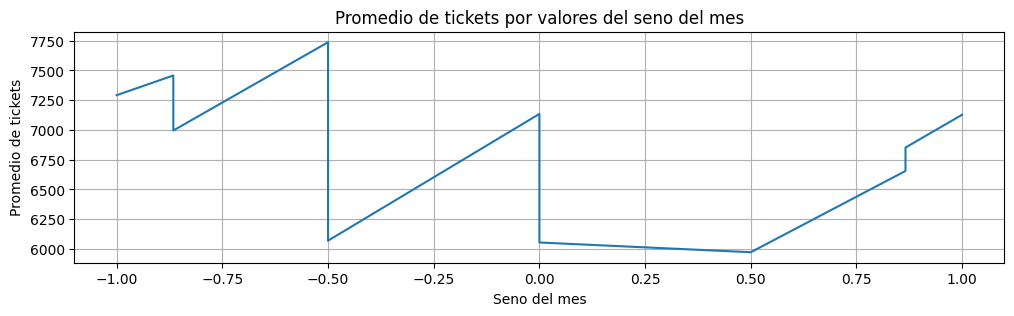

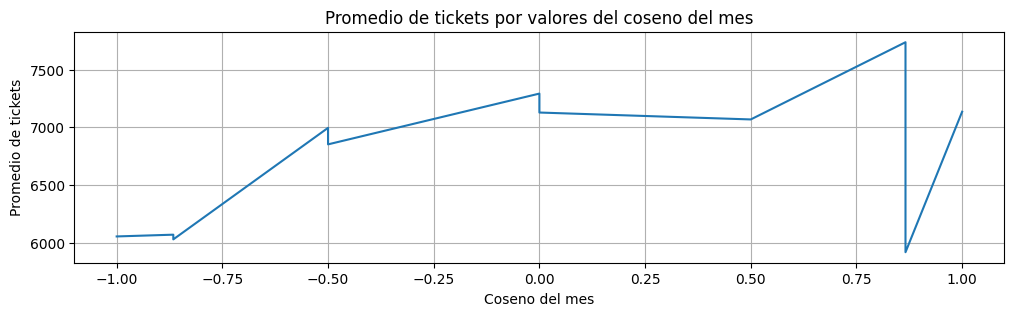

In [39]:
df_avg_sin = df_21_23.groupby('MONTH_SIN')['TICKETS'].mean().reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(x='MONTH_SIN', y='TICKETS', data=df_avg_sin)
plt.title('Promedio de tickets por valores del seno del mes')
plt.xlabel('Seno del mes')
plt.ylabel('Promedio de tickets')
plt.grid(True)
plt.show()

df_avg_cos = df_21_23.groupby('MONTH_COS')['TICKETS'].mean().reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(x='MONTH_COS', y='TICKETS', data=df_avg_cos)
plt.title('Promedio de tickets por valores del coseno del mes')
plt.xlabel('Coseno del mes')
plt.ylabel('Promedio de tickets')
plt.grid(True)
plt.show()

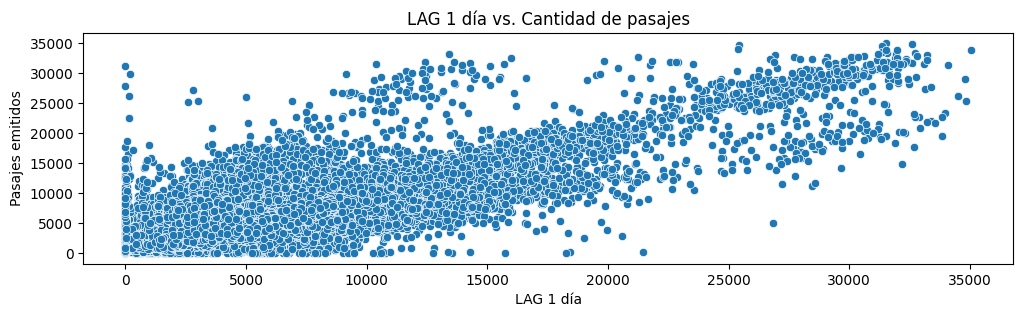

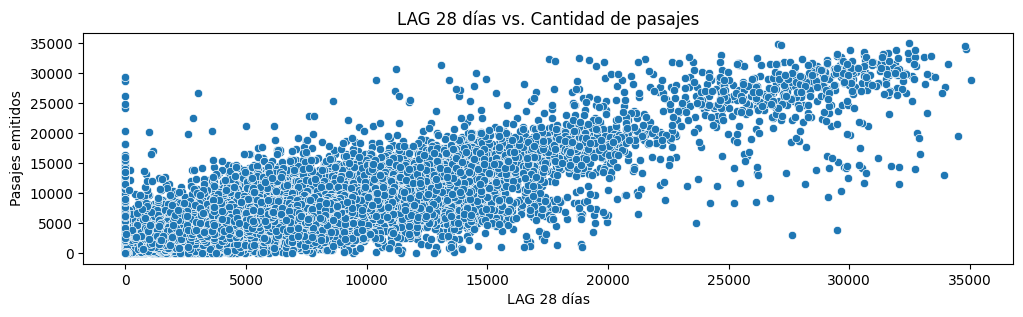

In [40]:
plt.figure(figsize=(12, 3))
sns.scatterplot(x=df_21_23['LAG_1'], y=df_21_23['TICKETS'])
plt.title('LAG 1 día vs. Cantidad de pasajes')
plt.xlabel('LAG 1 día')
plt.ylabel('Pasajes emitidos')
plt.show()

plt.figure(figsize=(12, 3))
sns.scatterplot(x=df_21_23['LAG_28'], y=df_21_23['TICKETS'])
plt.title('LAG 28 días vs. Cantidad de pasajes')
plt.xlabel('LAG 28 días')
plt.ylabel('Pasajes emitidos')
plt.show()

# Buscando datos 🥽

En esta seccion vamos a responder con datos algunas inquitudes

## 1 - Afectan los feriados a la demanda?

Para esto obtuve los feriados de Argentina y evaluo el antes, durante y despues de cada feriado nacional:

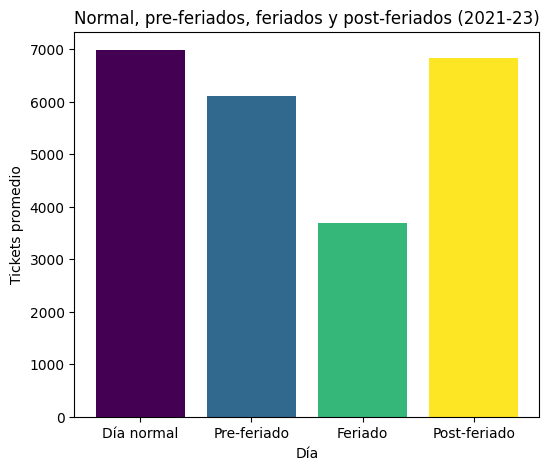

In [41]:
df_21_23['DAY_BEFORE_HOLIDAY'] = np.where(df_21_23['DATE'].shift(-1).isin(ar_holidays), True, False)
df_21_23['DAY_AFTER_HOLIDAY'] = np.where(df_21_23['DATE'].shift(1).isin(ar_holidays), True, False)

# Calculmos el promedio de tickets por tipo de día
tickets_comparison = df_21_23.groupby(['HOLIDAY', 'DAY_BEFORE_HOLIDAY', 'DAY_AFTER_HOLIDAY'])['TICKETS'].mean().reset_index()

# Creamos un diccionario para almacenar los promedios
avg_tickets = {
    'Día normal': tickets_comparison[
        (tickets_comparison['HOLIDAY'] == False) & 
        (tickets_comparison['DAY_BEFORE_HOLIDAY'] == False) & 
        (tickets_comparison['DAY_AFTER_HOLIDAY'] == False)
    ]['TICKETS'].values[0],
    'Pre-feriado': tickets_comparison[tickets_comparison['DAY_BEFORE_HOLIDAY'] == True]['TICKETS'].values[0],
    'Feriado': tickets_comparison[tickets_comparison['HOLIDAY'] == True]['TICKETS'].values[0],
    'Post-feriado': tickets_comparison[tickets_comparison['DAY_AFTER_HOLIDAY'] == True]['TICKETS'].values[0]
}

plt.figure(figsize=(6, 5))
days = list(avg_tickets.keys())
avg_values = list(avg_tickets.values())

colors = ['#440154', '#31688e', '#35b779', '#fde725']

plt.bar(days, avg_values, color=colors)
plt.xlabel('Día')
plt.ylabel('Tickets promedio')
plt.title('Normal, pre-feriados, feriados y post-feriados (2021-23)')
plt.show()

## 2 - Afecta la temperatura, la lluvia o el viento a la demanda?

Los datos los extraje de MeteoStat [( link a la web )](https://meteostat.net/es/place/ar/mar-del-plata?s=87692&t=2020-01-01/2023-12-31) y pertenecen al periodo:
> 1-1-2020 - 31-12-2023

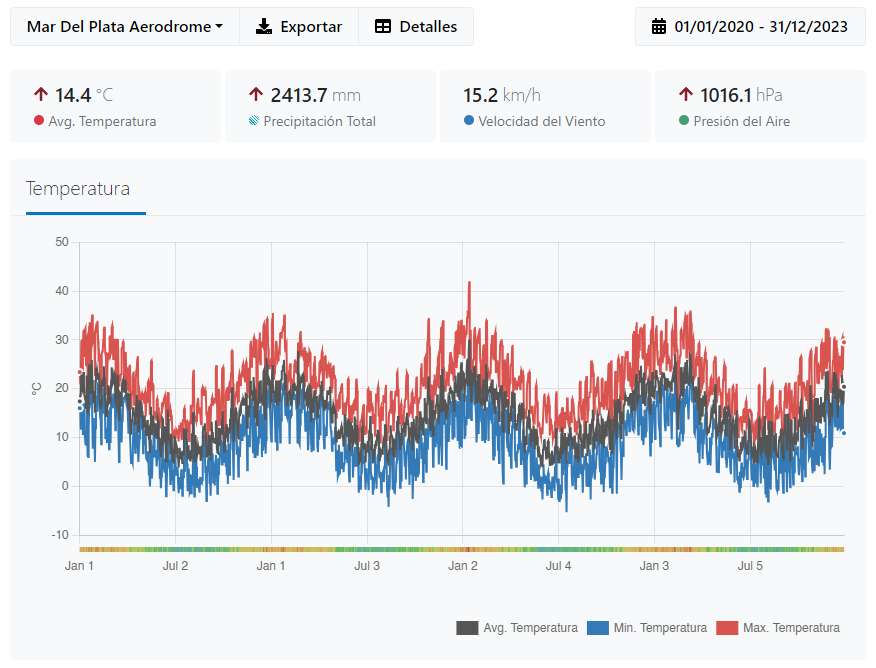

Podemos ver la fuerza del viento para nuestro periodo:

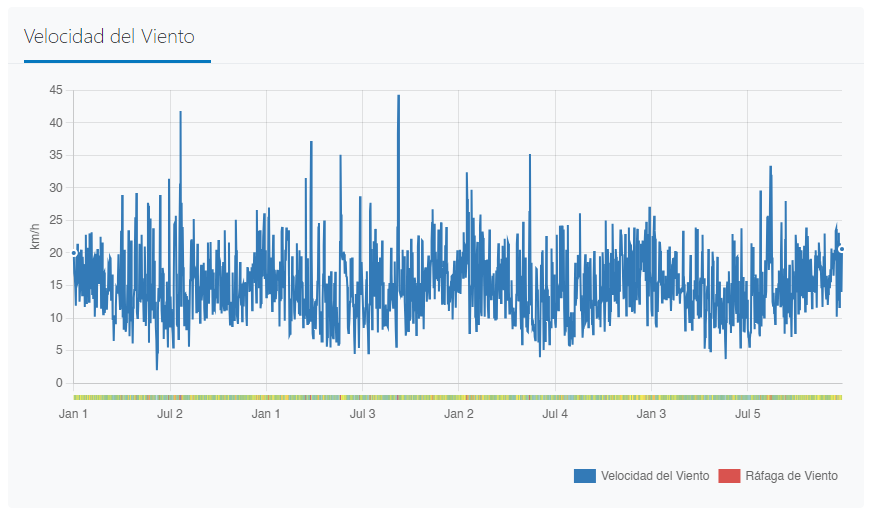

Podemos observar el patron de temperatura para la ciudad de mar del Plata segun el mes:

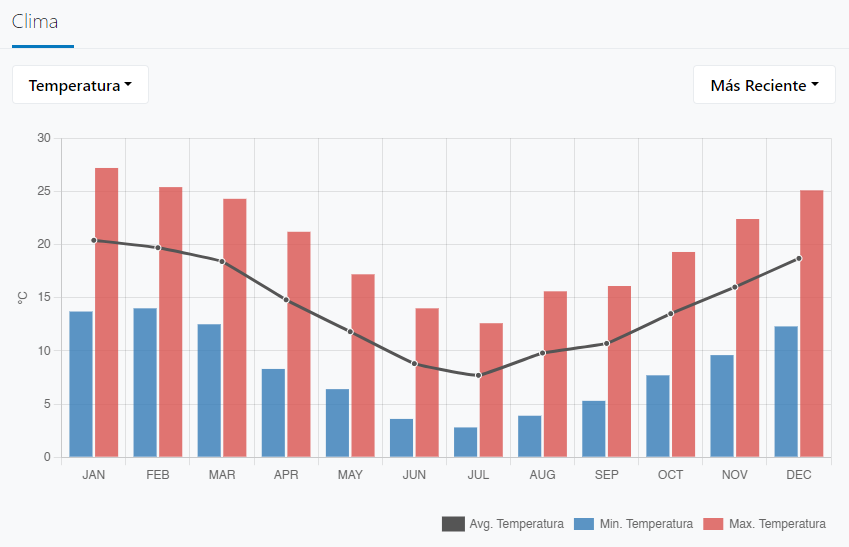

Por ultimo las precipitaciones de nuestro periodo:

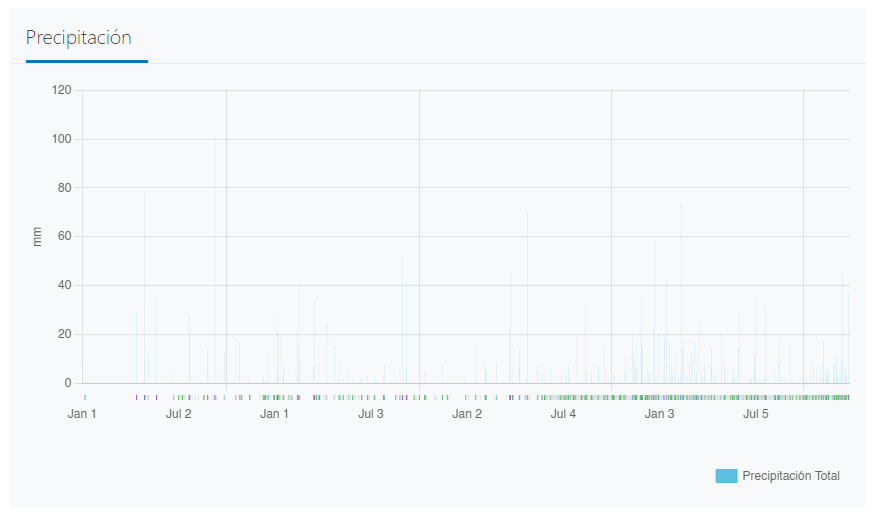



Desde **Meteostat** podemos descargar el historico del clima de la ciudad de Mar del Plata: [Link a los datos](https://meteostat.net/es/place/ar/mar-del-plata?s=87692&t=2020-01-01/2023-12-31)

En cuestion los datos que vamos a ocupar son:

Columna y descripción:

> **1	date	Fecha**

2	tavg	Avg. Temperatura

> **3	tmin	Min. Temperatura**

> **4	tmax	Max. Temperatura**

> **5	prcp	Precipitación Total**

6	snow	Profundidad de la Nieve

7	wdir	Dirección del Viento

8	wspd	Velocidad del Viento

9	wpgt	Ráfaga de Viento

10	pres	Presión del Aire

11	tsun	Duración del Sol

Descargamos el dataset y seleccionamos las columnas

In [42]:
df_21_23.head(10)

DATE  DAY  MONTH  YEAR     COMPANY  LINE_ID  TICKETS  DAY_OF_MONTH_SIN  DAY_OF_MONTH_COS  DAY_OF_WEEK  DAY_OF_WEEK_SIN  DAY_OF_WEEK_COS  HOLIDAY  WORKDAY  WEEKEND  SEASON  DAY_OF_YEAR  DAY_OF_YEAR_SIN  DAY_OF_YEAR_COS  WEEK_OF_YEAR  WEEK_OF_MONTH  MONTH_SIN  MONTH_COS  LAG_1  LAG_28  DAY_BEFORE_HOLIDAY  DAY_AFTER_HOLIDAY
9497 2021-01-01    1      1  2021  25 DE MAYO      501      331          0.201299          0.979530            5    -9.749279e-01        -0.222521        1        0        0       3            1         0.017213         0.999852            53              1        0.5   0.866025   3748    5212               False              False
9524 2021-01-02    2      1  2021  25 DE MAYO      501      830          0.394356          0.918958            6    -7.818315e-01         0.623490        0        0        1       3            2         0.034422         0.999407            53              1        0.5   0.866025    331    5262               False               True
9551 2021-01-03    3      1  2021  25 DE MAYO      501     1134          0.571268          0.820763            7    -2.449294e-16         1.000000        0        0        1       3            3         0.051620         0.998667            53              1        0.5   0.866025    830    2554               False              False
9578 2021-01-04    4      1  2021  25 DE MAYO      501     1087          0.724793          0.688967            1     7.818315e-01         0.623490        0        1        0       3            4         0.068802         0.997630             1              1        0.5   0.866025   1134    3828               False              False
9605 2021-01-05    5      1  2021  25 DE MAYO      501     2633          0.848644          0.528964            2     9.749279e-01        -0.222521        0        1        0       3            5         0.085965         0.996298             1              1        0.5   0.866025   1087    3410               False              False
9632 2021-01-06    6      1  2021  25 DE MAYO      501     1742          0.937752          0.347305            3     4.338837e-01        -0.900969        0        1        0       3            6         0.103102         0.994671             1              1        0.5   0.866025   2633    6094               False              False
9659 2021-01-07    7      1  2021  25 DE MAYO      501      840          0.988468          0.151428            4    -4.338837e-01        -0.900969        0        1        0       3            7         0.120208         0.992749             1              1        0.5   0.866025   1742    3586               False              False
9686 2021-01-08    8      1  2021  25 DE MAYO      501      563          0.998717         -0.050649            5    -9.749279e-01        -0.222521        0        1        0       3            8         0.137279         0.990532             1              2        0.5   0.866025    840    3648               False              False
9713 2021-01-09    9      1  2021  25 DE MAYO      501      591          0.968077         -0.250653            6    -7.818315e-01         0.623490        0        0        1       3            9         0.154309         0.988023             1              2        0.5   0.866025    563    2864               False              False
9740 2021-01-10   10      1  2021  25 DE MAYO      501     1866          0.897805         -0.440394            7    -2.449294e-16         1.000000        0        0        1       3           10         0.171293         0.985220             1              2        0.5   0.866025    591    1026               False              False

In [43]:
weather = pd.read_csv("Datasets/weather.csv")
weather.head(10)

date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
0  2020-01-01  17.4  16.0  23.4   NaN   NaN   160  20.0   NaN  1017.2   NaN
1  2020-01-02  18.6  15.7  21.1   NaN   NaN   103  16.9   NaN  1021.6   NaN
2  2020-01-03  18.9  11.8  22.5   NaN   NaN    51  16.3   NaN  1022.0   NaN
3  2020-01-04  22.9  11.8  29.6   NaN   NaN   340  14.7   NaN  1013.5   NaN
4  2020-01-05  20.0  17.9  30.1   NaN   NaN    34  11.9   NaN  1006.0   NaN
5  2020-01-06  19.7  15.9  22.7   9.1   NaN   271  19.4   NaN  1000.9   NaN
6  2020-01-07  19.7  10.5  28.1   NaN   NaN   309  17.5   NaN  1004.7   NaN
7  2020-01-08  23.4  15.3  31.7   NaN   NaN   322  21.4   NaN  1004.7   NaN
8  2020-01-09  20.8  17.0  32.1   NaN   NaN   241  15.7   NaN  1007.4   NaN
9  2020-01-10  18.7  11.4  26.7   NaN   NaN   259  16.0   NaN  1010.8   NaN

Hacemos una copia de nuestro df y agrupamos sumando por dia

In [44]:
# Agrupar por las demás columnas y sumar los tickets
df_daily = df_21_23.groupby(['YEAR','MONTH', 'DAY'], as_index=False)['TICKETS'].sum()
# Verificar la copia del DataFrame
print(df_daily.head())

   YEAR  MONTH  DAY  TICKETS
0  2021      1    1    24794
1  2021      1    2    58561
2  2021      1    3   110429
3  2021      1    4   109282
4  2021      1    5   115442


Agregamos esta nueva informacion a nuestro dataset principal

In [45]:
weather['date'] = pd.to_datetime(weather['date'])

# Separar la columna de fecha en YEAR, MONTH, DAY
weather['YEAR'] = weather['date'].dt.year
weather['MONTH'] = weather['date'].dt.month
weather['DAY'] = weather['date'].dt.day

# Unir los datos climáticos con tu dataframe original
weather = pd.merge(df_daily, weather[['YEAR', 'MONTH', 'DAY', 'tavg', 'prcp', 'wspd']], how='left', on=['YEAR', 'MONTH', 'DAY'])

# Renombrar las columnas si es necesario
weather.rename(columns={'tavg': 'TEMP', 'prcp': 'PREP', 'wspd': 'WSPEED'}, inplace=True)
weather.head(10)

YEAR  MONTH  DAY  TICKETS  TEMP  PREP  WSPEED
0  2021      1    1    24794  17.6   NaN    13.2
1  2021      1    2    58561  21.7   NaN    14.1
2  2021      1    3   110429  24.9   NaN    16.8
3  2021      1    4   109282  21.1   NaN    13.6
4  2021      1    5   115442  19.3   3.0    25.4
5  2021      1    6   109562  19.4  21.1    27.0
6  2021      1    7   110774  19.4  27.9    19.0
7  2021      1    8    88078  18.4   4.1    13.8
8  2021      1    9    61860  17.1   0.0    14.2
9  2021      1   10   109326  21.7   NaN    19.3

Tenemos valores nan, procedemos a igualarlos a 0:

In [46]:
nan_counts = weather.isna().sum()
print(nan_counts)


YEAR         0
MONTH        0
DAY          0
TICKETS      0
TEMP         0
PREP       400
WSPEED       0
dtype: int64


In [47]:
weather = weather.fillna(0)

nan_counts = weather.isna().sum()
weather.head()

YEAR  MONTH  DAY  TICKETS  TEMP  PREP  WSPEED
0  2021      1    1    24794  17.6   0.0    13.2
1  2021      1    2    58561  21.7   0.0    14.1
2  2021      1    3   110429  24.9   0.0    16.8
3  2021      1    4   109282  21.1   0.0    13.6
4  2021      1    5   115442  19.3   3.0    25.4

Busquemos correlaciones entre el clima y la demanda de transporte, para esto vamos a utilizar 2022 y 2023 ya que no fueron afectados por la pandemia, y los podemos considerar de consumo normal

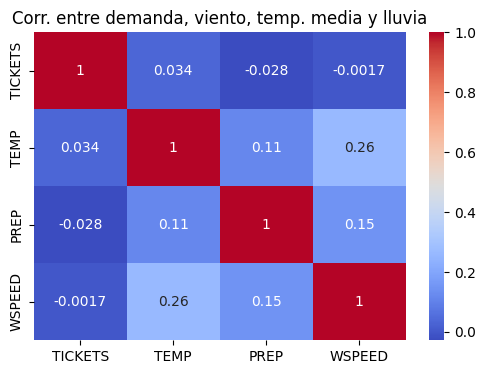

In [48]:
# Calcular la matriz de correlaciones
correlaciones = weather[['TICKETS', 'TEMP', 'PREP', 'WSPEED']].corr()

# Graficar la matriz de correlaciones
plt.figure(figsize=(6, 4))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', cbar=True)
plt.title('Corr. entre demanda, viento, temp. media y lluvia')
plt.show()

Las correlaciones son bajas, indicando que, en este subconjunto de datos, no hay una relación lineal significativa entre el número de tickets y la temperatura o la precipitacion.

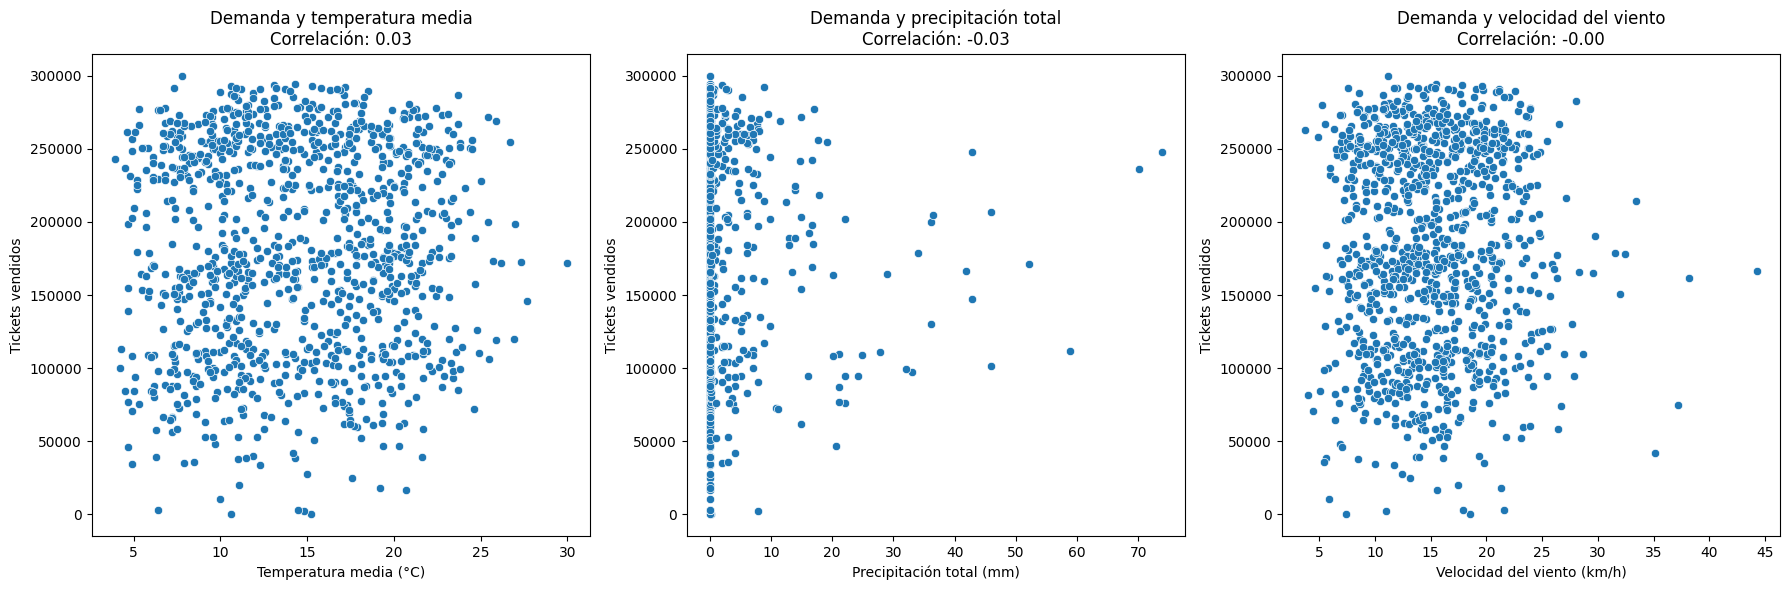

In [49]:
from scipy.stats import pearsonr

# Crear la figura y los subplots
plt.figure(figsize=(18, 6))

# Gráfico de temperatura media y demanda de transporte con coeficiente de correlación
plt.subplot(1, 3, 1)
sns.scatterplot(x='TEMP', y='TICKETS', data=weather)
corr_temp, _ = pearsonr(weather['TEMP'], weather['TICKETS'])
plt.title(f'Demanda y temperatura media\nCorrelación: {corr_temp:.2f}')
plt.xlabel('Temperatura media (°C)')
plt.ylabel('Tickets vendidos')

# Gráfico de precipitación total y demanda de transporte con coeficiente de correlación
plt.subplot(1, 3, 2)
sns.scatterplot(x='PREP', y='TICKETS', data=weather)
corr_prep, _ = pearsonr(weather['PREP'], weather['TICKETS'])
plt.title(f'Demanda y precipitación total\nCorrelación: {corr_prep:.2f}')
plt.xlabel('Precipitación total (mm)')
plt.ylabel('Tickets vendidos')

# Gráfico de velocidad del viento y demanda de transporte con coeficiente de correlación
plt.subplot(1, 3, 3)
sns.scatterplot(x='WSPEED', y='TICKETS', data=weather)
corr_wspeed, _ = pearsonr(weather['WSPEED'], weather['TICKETS'])
plt.title(f'Demanda y velocidad del viento\nCorrelación: {corr_wspeed:.2f}')
plt.xlabel('Velocidad del viento (km/h)')
plt.ylabel('Tickets vendidos')

# Ajustar el diseño de los subplots
plt.tight_layout()
plt.show()

Temperatura Media (TEMP):
La correlación entre la demanda de boletos y la temperatura media es muy baja (0.034). Esto sugiere que no existe una relación significativa entre la temperatura y la demanda de transporte público. Los datos de dispersión corroboran esta conclusión, mostrando una distribución uniforme de la demanda de boletos a través de diferentes rangos de temperatura.

Precipitación Total (PREP):
La correlación entre la demanda de boletos y la precipitación total es negativa pero muy baja (-0.028). Esta débil correlación negativa indica que la lluvia no tiene un impacto considerable en la demanda de transporte público. El diagrama de dispersión muestra que la mayoría de los datos se agrupan cerca de niveles bajos de precipitación, sin una clara tendencia observable en la demanda de boletos.

Velocidad del Viento (WSPEED):
La correlación entre la demanda de boletos y la velocidad del viento es prácticamente nula (-0.0017). Esto indica que la velocidad del viento no afecta significativamente la demanda de transporte público. El diagrama de dispersión respalda esta conclusión, mostrando una dispersión aleatoria de los datos sin una tendencia discernible.

Conclusiones:
Las correlaciones bajas o nulas entre las variables climáticas y la demanda sugieren que, en este caso, el clima no juega un papel crucial en la variación de la demanda de transporte público en la ciudad. Esto podría deberse a varios factores, como la prevalencia de hábitos de transporte que no se ven afectados por el clima, o una adaptación de los usuarios al clima local.



## Ocupacion de mercado

Evaluemos ahora variacion de la ocupacion de mercado de cada empresa. Vamos a contrastar 2020 con 2023.

In [50]:
df_21_23[df_21_23['COMPANY'] == '25 DE MAYO'].head(10)


DATE  DAY  MONTH  YEAR     COMPANY  LINE_ID  TICKETS  DAY_OF_MONTH_SIN  DAY_OF_MONTH_COS  DAY_OF_WEEK  DAY_OF_WEEK_SIN  DAY_OF_WEEK_COS  HOLIDAY  WORKDAY  WEEKEND  SEASON  DAY_OF_YEAR  DAY_OF_YEAR_SIN  DAY_OF_YEAR_COS  WEEK_OF_YEAR  WEEK_OF_MONTH  MONTH_SIN  MONTH_COS  LAG_1  LAG_28  DAY_BEFORE_HOLIDAY  DAY_AFTER_HOLIDAY
9497 2021-01-01    1      1  2021  25 DE MAYO      501      331          0.201299          0.979530            5    -9.749279e-01        -0.222521        1        0        0       3            1         0.017213         0.999852            53              1        0.5   0.866025   3748    5212               False              False
9524 2021-01-02    2      1  2021  25 DE MAYO      501      830          0.394356          0.918958            6    -7.818315e-01         0.623490        0        0        1       3            2         0.034422         0.999407            53              1        0.5   0.866025    331    5262               False               True
9551 2021-01-03    3      1  2021  25 DE MAYO      501     1134          0.571268          0.820763            7    -2.449294e-16         1.000000        0        0        1       3            3         0.051620         0.998667            53              1        0.5   0.866025    830    2554               False              False
9578 2021-01-04    4      1  2021  25 DE MAYO      501     1087          0.724793          0.688967            1     7.818315e-01         0.623490        0        1        0       3            4         0.068802         0.997630             1              1        0.5   0.866025   1134    3828               False              False
9605 2021-01-05    5      1  2021  25 DE MAYO      501     2633          0.848644          0.528964            2     9.749279e-01        -0.222521        0        1        0       3            5         0.085965         0.996298             1              1        0.5   0.866025   1087    3410               False              False
9632 2021-01-06    6      1  2021  25 DE MAYO      501     1742          0.937752          0.347305            3     4.338837e-01        -0.900969        0        1        0       3            6         0.103102         0.994671             1              1        0.5   0.866025   2633    6094               False              False
9659 2021-01-07    7      1  2021  25 DE MAYO      501      840          0.988468          0.151428            4    -4.338837e-01        -0.900969        0        1        0       3            7         0.120208         0.992749             1              1        0.5   0.866025   1742    3586               False              False
9686 2021-01-08    8      1  2021  25 DE MAYO      501      563          0.998717         -0.050649            5    -9.749279e-01        -0.222521        0        1        0       3            8         0.137279         0.990532             1              2        0.5   0.866025    840    3648               False              False
9713 2021-01-09    9      1  2021  25 DE MAYO      501      591          0.968077         -0.250653            6    -7.818315e-01         0.623490        0        0        1       3            9         0.154309         0.988023             1              2        0.5   0.866025    563    2864               False              False
9740 2021-01-10   10      1  2021  25 DE MAYO      501     1866          0.897805         -0.440394            7    -2.449294e-16         1.000000        0        0        1       3           10         0.171293         0.985220             1              2        0.5   0.866025    591    1026               False              False

In [51]:
df_21_23[(df_21_23['LINE_ID'] == 553) & (df_21_23['MONTH'] == 5) & (df_21_23['DAY'] == 5)].head(10)

DATE  DAY  MONTH  YEAR        COMPANY  LINE_ID  TICKETS  DAY_OF_MONTH_SIN  DAY_OF_MONTH_COS  DAY_OF_WEEK  DAY_OF_WEEK_SIN  DAY_OF_WEEK_COS  HOLIDAY  WORKDAY  WEEKEND  SEASON  DAY_OF_YEAR  DAY_OF_YEAR_SIN  DAY_OF_YEAR_COS  WEEK_OF_YEAR  WEEK_OF_MONTH  MONTH_SIN  MONTH_COS  LAG_1  LAG_28  DAY_BEFORE_HOLIDAY  DAY_AFTER_HOLIDAY
12853 2021-05-05    5      5  2021     25 DE MAYO      553     4499          0.848644          0.528964            3         0.433884        -0.900969        0        1        0       1          125         0.835925        -0.548843            18              1        0.5  -0.866025   3953    3784               False              False
22622 2022-05-05    5      5  2022     25 DE MAYO      553     8497          0.848644          0.528964            4        -0.433884        -0.900969        0        1        0       1          125         0.835925        -0.548843            18              1        0.5  -0.866025   7466    5543               False              False
32513 2023-05-05    5      5  2023  PERALTA RAMOS      553     6020          0.848644          0.528964            5        -0.974928        -0.222521        0        1        0       1          125         0.835925        -0.548843            18              1        0.5  -0.866025   6092    2859               False              False

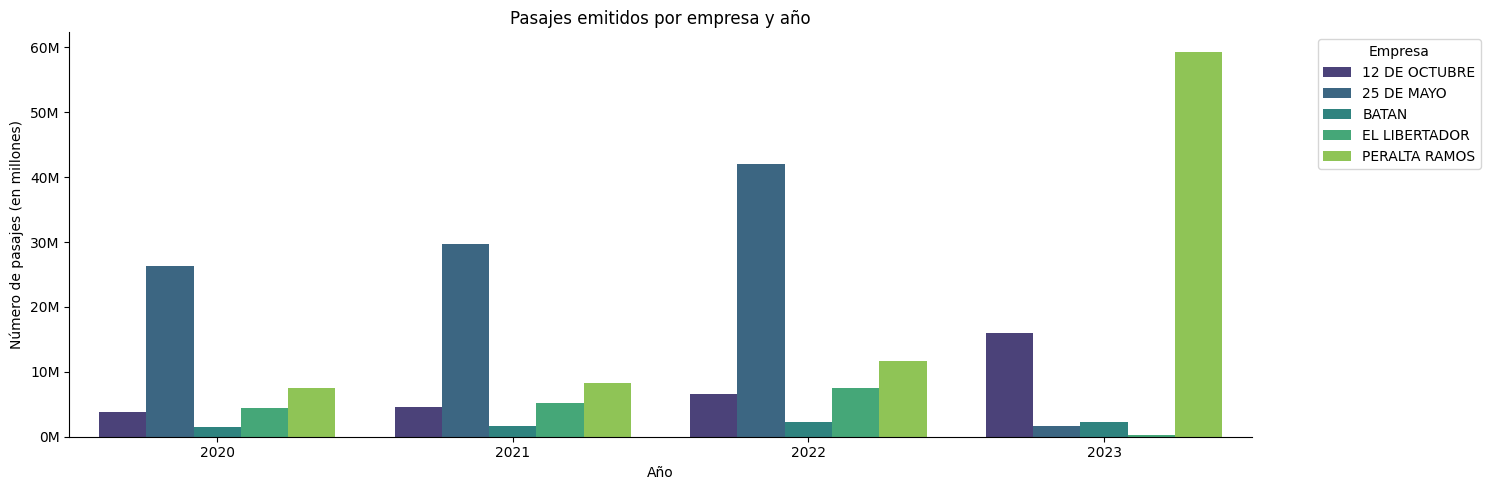

In [52]:
# Agrupar los datos por año y empresa, sumando los tickets
tickets_por_compania_ano = df.groupby(['YEAR', 'COMPANY'])['TICKETS'].sum().reset_index()

# Crear el gráfico de barras con desagregación por año y empresa
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=tickets_por_compania_ano, x='YEAR', y='TICKETS', hue='COMPANY', palette='viridis', dodge=True, ax=ax)

# Título y etiquetas del gráfico
plt.title('Pasajes emitidos por empresa y año')
plt.xlabel('Año')
plt.ylabel('Número de pasajes (en millones)')

# Formatear las etiquetas del eje y para mostrar valores en millones
def millions(x, pos):
    return '{:,.0f}M'.format(x / 1e6)

ax.yaxis.set_major_formatter(FuncFormatter(millions))

# Rotar las etiquetas del eje x para una mejor visualización si es necesario
plt.xticks(rotation=0)

# Quitar las líneas superior y derecha del gráfico para un aspecto más limpio
sns.despine(top=True, right=True)

# Mostrar la leyenda
plt.legend(title='Empresa', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

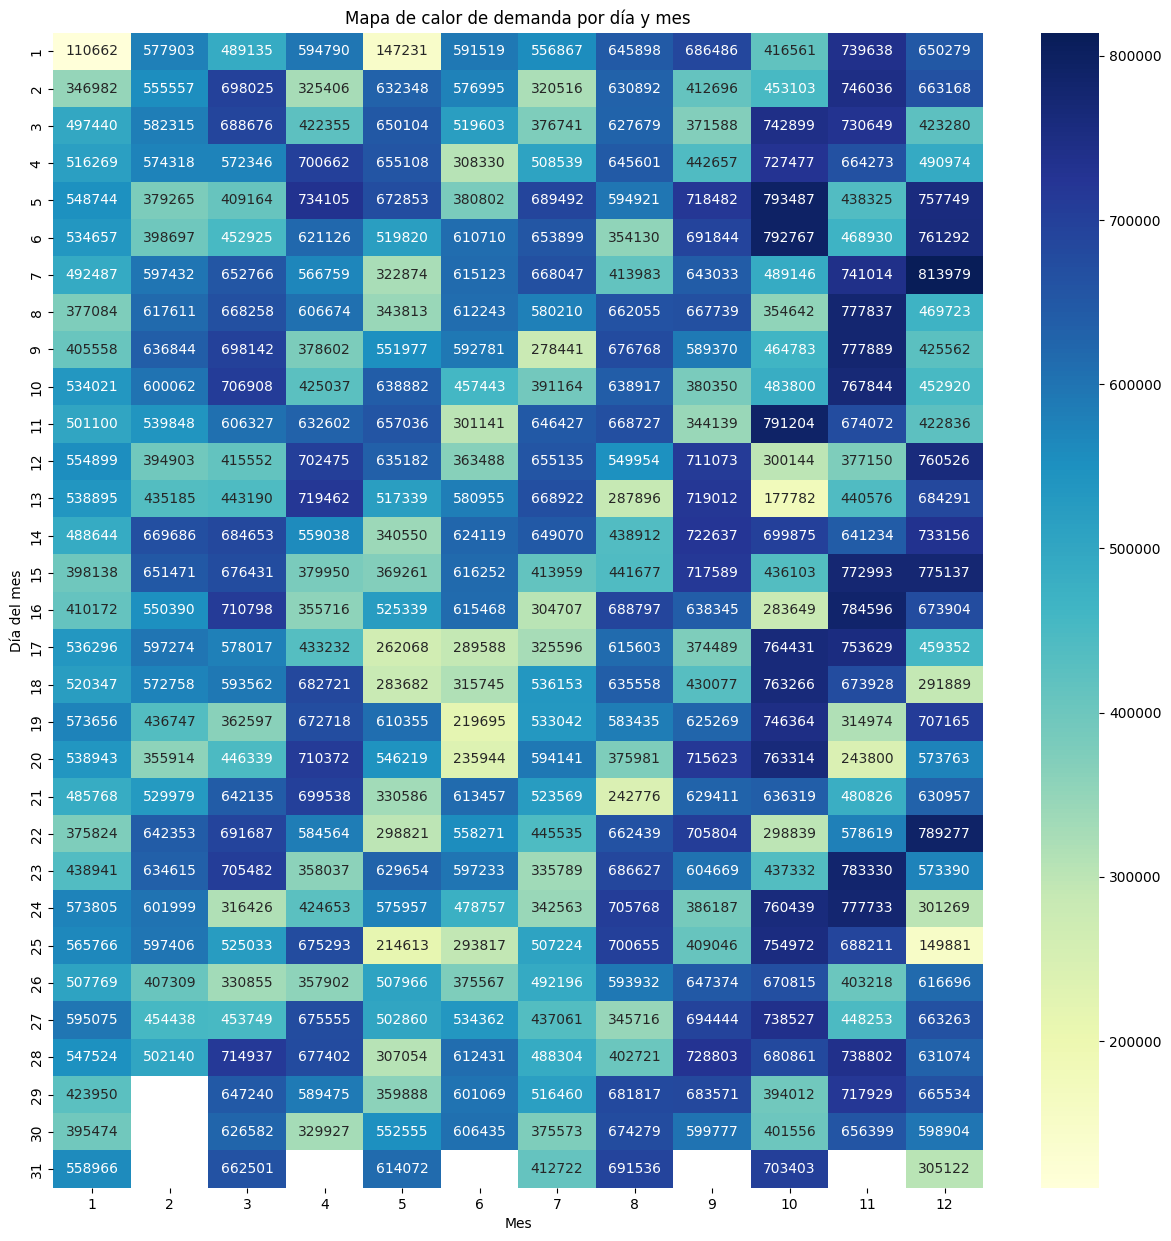

In [53]:
# Crear una tabla pivote con la suma de boletos por día y mes
pivot_table = df_21_23.pivot_table(values='TICKETS', index='DAY', columns='MONTH', aggfunc='sum')

# Gráfico de mapa de calor
plt.figure(figsize=(15, 15))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='g')
plt.title('Mapa de calor de demanda por día y mes')
plt.xlabel('Mes')
plt.ylabel('Día del mes')
plt.show()

Analisis de demanda por linea de transporte:

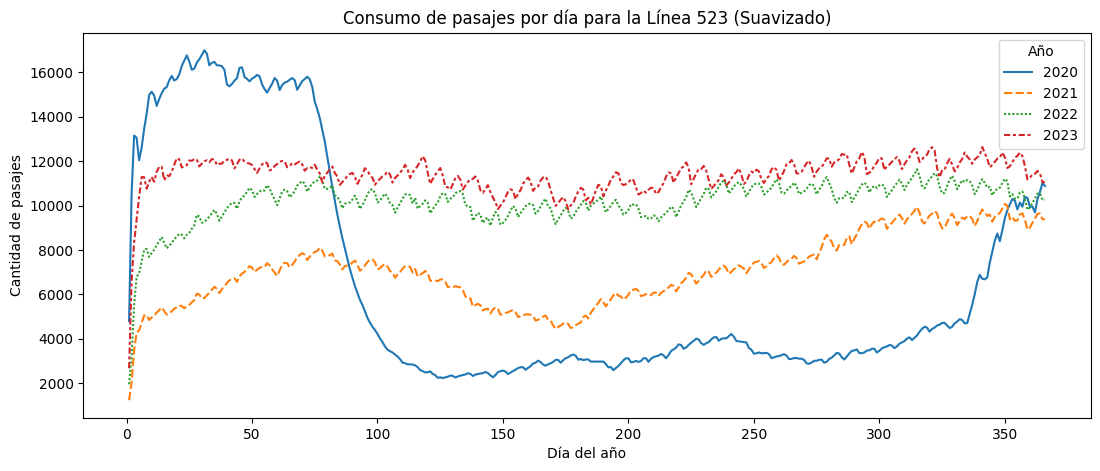

In [54]:
# Filtramos los datos para la línea específica, por ejemplo, la línea 523
linea_especifica = df[df['LINE_ID'] == 523]

# Creamos una columna 'DAY_OF_YEAR' para representar el día del año
linea_especifica['DATE'] = pd.to_datetime(linea_especifica[['YEAR', 'MONTH', 'DAY']])
linea_especifica['DAY_OF_YEAR'] = linea_especifica['DATE'].dt.dayofyear

# Agrupamos por día del año y año, y sumamos los tickets
grouped = linea_especifica.groupby(['DAY_OF_YEAR', 'YEAR'])['TICKETS'].sum().reset_index()

# Pivotamos para tener una columna por año
pivot_table = grouped.pivot(index='DAY_OF_YEAR', columns='YEAR', values='TICKETS')

# Aplicamos suavizado exponencial
pivot_table_smooth = pivot_table.ewm(span=30).mean()

# Graficamos
plt.figure(figsize=(13, 5))
sns.lineplot(data=pivot_table_smooth)
plt.title('Consumo de pasajes por día para la Línea 523 (Suavizado)')
plt.xlabel('Día del año')
plt.ylabel('Cantidad de pasajes')
plt.legend(title='Año')
plt.show()

<Figure size 1200x800 with 0 Axes>

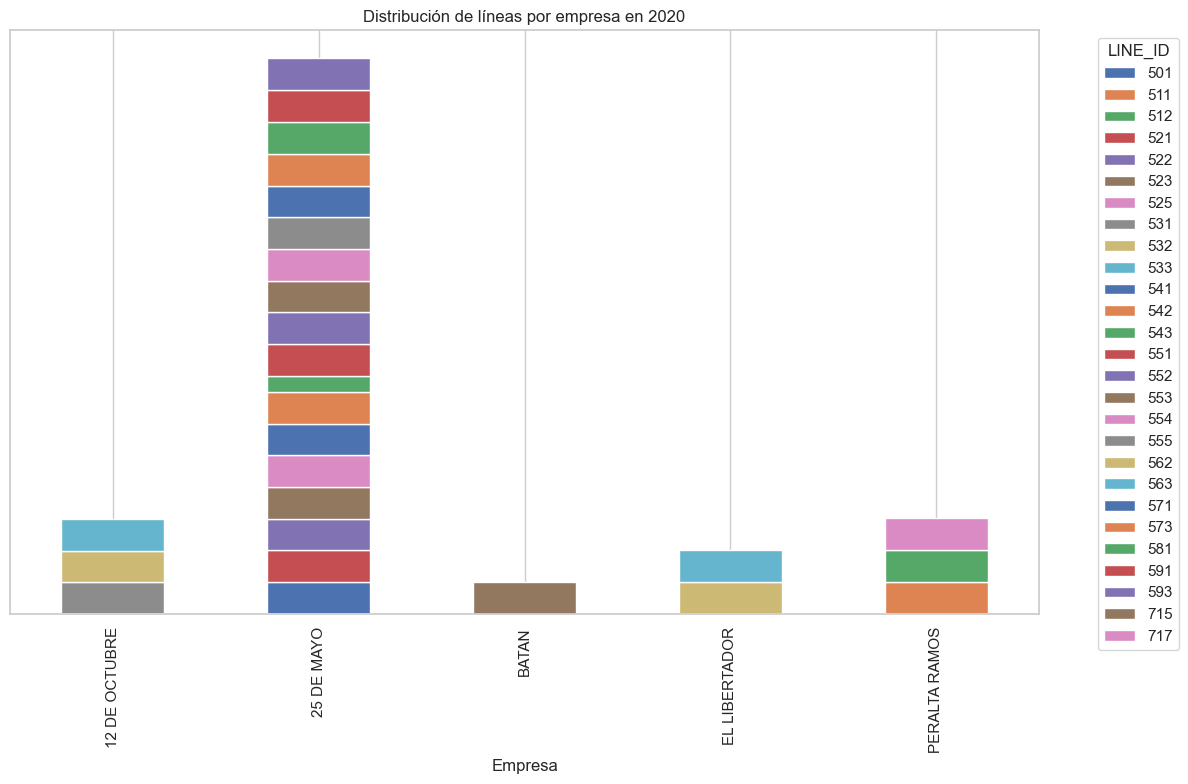

In [55]:
df_c = df[df['YEAR'] == 2020].copy()

sns.set(style="whitegrid")

tabla_cruzada = pd.crosstab(df_c['COMPANY'], df_c['LINE_ID'])

plt.figure(figsize=(12, 8))
ax = tabla_cruzada.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Distribución de líneas por empresa en 2020')
plt.xlabel('Empresa')

ax.yaxis.set_visible(False)

plt.legend(title='LINE_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

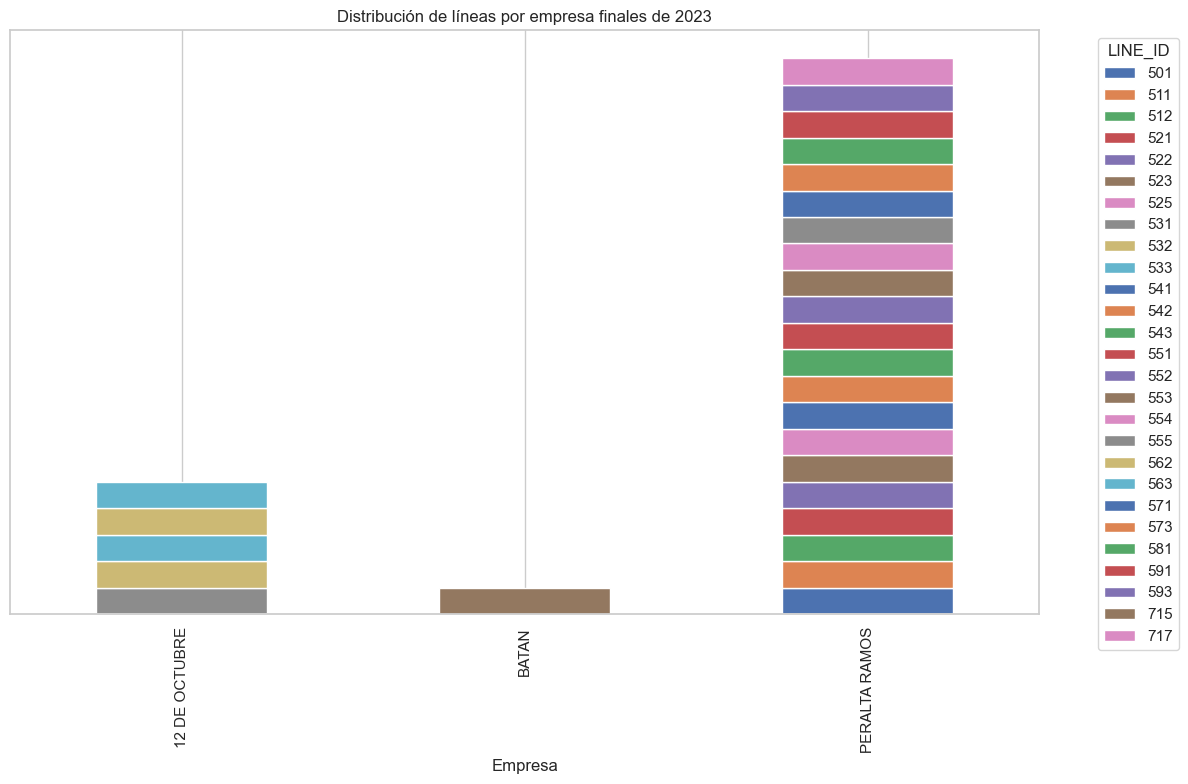

In [56]:
df_c = df[(df['YEAR'] == 2023) & (df['MONTH'] > 5)].copy()

sns.set(style="whitegrid")

tabla_cruzada = pd.crosstab(df_c['COMPANY'], df_c['LINE_ID'])

plt.figure(figsize=(12, 8))
ax = tabla_cruzada.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Distribución de líneas por empresa finales de 2023')
plt.xlabel('Empresa')

ax.yaxis.set_visible(False)

plt.legend(title='LINE_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Guardamos el dataset resultante junto a las nuevas caracteristicas a fin de evaluarlas y generar un modelo de prediccion de demanda:

In [57]:
df_21_23.head()

DATE  DAY  MONTH  YEAR     COMPANY  LINE_ID  TICKETS  DAY_OF_MONTH_SIN  DAY_OF_MONTH_COS  DAY_OF_WEEK  DAY_OF_WEEK_SIN  DAY_OF_WEEK_COS  HOLIDAY  WORKDAY  WEEKEND  SEASON  DAY_OF_YEAR  DAY_OF_YEAR_SIN  DAY_OF_YEAR_COS  WEEK_OF_YEAR  WEEK_OF_MONTH  MONTH_SIN  MONTH_COS  LAG_1  LAG_28  DAY_BEFORE_HOLIDAY  DAY_AFTER_HOLIDAY
9497 2021-01-01    1      1  2021  25 DE MAYO      501      331          0.201299          0.979530            5    -9.749279e-01        -0.222521        1        0        0       3            1         0.017213         0.999852            53              1        0.5   0.866025   3748    5212               False              False
9524 2021-01-02    2      1  2021  25 DE MAYO      501      830          0.394356          0.918958            6    -7.818315e-01         0.623490        0        0        1       3            2         0.034422         0.999407            53              1        0.5   0.866025    331    5262               False               True
9551 2021-01-03    3      1  2021  25 DE MAYO      501     1134          0.571268          0.820763            7    -2.449294e-16         1.000000        0        0        1       3            3         0.051620         0.998667            53              1        0.5   0.866025    830    2554               False              False
9578 2021-01-04    4      1  2021  25 DE MAYO      501     1087          0.724793          0.688967            1     7.818315e-01         0.623490        0        1        0       3            4         0.068802         0.997630             1              1        0.5   0.866025   1134    3828               False              False
9605 2021-01-05    5      1  2021  25 DE MAYO      501     2633          0.848644          0.528964            2     9.749279e-01        -0.222521        0        1        0       3            5         0.085965         0.996298             1              1        0.5   0.866025   1087    3410               False              False

In [58]:
df_21_23 = df_21_23.sort_values(by=['YEAR', 'MONTH', 'DAY', 'LINE_ID'])

df_21_23.to_csv('Datasets/sube-explored.csv', index=False)
df_20.to_csv('Datasets/sube-2020.csv', index=False)